In [1]:
# Version 2025-07-28

# All basis code provided by H&M
# Edited by Patrik Johansson
# Imported functions are created by H&M unless open source
import sys
sys.path.append('/home/jupyter/')
import os

import numpy as np
import pandas as pd
import scipy.stats as st

import seaborn as sns
import matplotlib.pyplot as plt

# Special methods written by H&M
from stats import reqSS_means
from plotting import plot_summary

from numpy.random import default_rng

import math

colors = sns.color_palette()

In [2]:
alpha = 0.05 # significance level
beta = 0.2 # type 2 error rate, test power is 1 - beta
mde = 0.05 # 0.01 and 0.05 optimally, but was at start = 0.1

# control group
mu_c = 3
var_c = 1
# treatment group
mu_t = mu_c*(1.+(mde))
var_t = 1


# number of observations for control
nobs_c = reqSS_means(mu_c, var_c, mde, alpha, beta, direction = "two-sided")
# nobs_c = 1000*(nobs_c//1000)+1000
nobs_c_x2 = nobs_c*2

# number of observations for treatment 
nobs_t = reqSS_means(mu_c, var_c, mde, alpha, beta, direction = "two-sided")
# nobs_t = 1000*(nobs_t//1000)+1000
nobs_t_x2 = nobs_t*2

# number of experiments
n_exps = 200

# obs_step = 100

# alternative: two-sided, less, greater
alternative = "two-sided"

In [3]:
rand_gen = default_rng(seed=42)

In [4]:
def sampling(distribution, transformation, control, treatment, nobs):
    a_data = rand_gen.normal(control, np.sqrt(control), nobs)
    aa_data = rand_gen.normal(control, np.sqrt(control), nobs)
    ab_data = rand_gen.normal(treatment, np.sqrt(treatment), nobs)

In [220]:
def ab_test(dist, trans, mod, nobs, mean, var, mde, n_exps, chosen_seed, seed_change):
    rand_gen = default_rng(seed=chosen_seed)

    pvalues_aa = []
    pvalues_ab = []

    """
    print("AB_TEST")
    print(f"Dist = {dist}")
    print(f"Trans = {trans}")
    print(f"Mod = {mod}")
    print(f"nobs = {nobs}")
    print(f"mean = {mean}")
    print(f"var = {var}")
    print(f"mde = {mde}")
    print(f"n_exps = {n_exps}")
    print(f"chosen_seed = {chosen_seed}")
    print(f"seed_change = {seed_change}")
    print("\n")
    """

    treatment = mean*(1.+(mde))


    for exp_num in range(n_exps):
        
        if (seed_change > 0) and (exp_num != 0):
            chosen_seed += seed_change
            rand_gen = default_rng(seed=chosen_seed)

        #generate_data
        if dist == "Poisson":
            a_data = rand_gen.poisson(mean, int(nobs))
            aa_data = rand_gen.poisson(mean, int(nobs))
            ab_data = rand_gen.poisson(treatment, int(nobs))
        elif dist == "Discrete Uniform":
            a_data = rand_gen.integers(np.round((mean - 3*np.sqrt(var)), 0), np.round((mean + 3*np.sqrt(var) + 1), 0), int(nobs))
            aa_data = rand_gen.integers(np.round((mean - 3*np.sqrt(var)), 0), np.round((mean + 3*np.sqrt(var) + 1), 0), int(nobs))
            ab_data = rand_gen.integers(np.round(((treatment) - 3*np.sqrt(var)), 0), np.round(((treatment) + 3*np.sqrt(var) + 1), 0), int(nobs))
        elif dist == "Laplace":
            a_data = rand_gen.laplace(mean, np.sqrt(var/2), int(nobs))
            aa_data = rand_gen.laplace(mean, np.sqrt(var/2), int(nobs))
            ab_data = rand_gen.laplace(treatment, np.sqrt(var/2), int(nobs))
        elif dist == "Dlaplace":
            a_data = st.dlaplace.rvs((np.log((1+var+np.sqrt(1+2*var))/var)), loc=mean, size=int(nobs), random_state=rand_gen)
            aa_data = st.dlaplace.rvs((np.log((1+var+np.sqrt(1+2*var))/var)), loc=mean, size=int(nobs), random_state=rand_gen)
            ab_data = st.dlaplace.rvs((np.log((1+var+np.sqrt(1+2*var))/var)), loc=treatment, size=int(nobs), random_state=rand_gen)
        else: # Normal distribution by default
            a_data = rand_gen.normal(mean, np.sqrt(var), int(nobs))
            aa_data = rand_gen.normal(mean, np.sqrt(var), int(nobs))
            ab_data = rand_gen.normal(treatment, np.sqrt(var), int(nobs))
        
        # cast arrays to handle transformations with changes
        a_data = np.array(a_data, dtype=float)
        aa_data = np.array(aa_data, dtype=float)
        ab_data = np.array(ab_data, dtype=float)

        # modify data for transformation
        if mod == 0:
            a_data[a_data <= 0] = 1
            aa_data[aa_data <= 0] = 1
            ab_data[ab_data <= 0] = 1
        elif mod == 1 or mod == 11:
            a_data += 1
            aa_data += 1
            ab_data += 1
        elif mod == 10:
            a_data[a_data <= 0] = 1e-10
            aa_data[aa_data <= 0] = 1e-10
            ab_data[ab_data <= 0] = 1e-10


        # action based on transformation used
        if trans == "Log" or trans == "Logarithmic":
            a_data = np.log(a_data)
            aa_data = np.log(aa_data)
            ab_data = np.log(ab_data) 
        elif trans == "BC" or trans == "Box-Cox":
            a_data, a_lambda = st.boxcox(a_data)
            aa_data, aa_lambda = st.boxcox(aa_data)
            ab_data, ab_lambda = st.boxcox(ab_data)

        # 11 is heuristical approach where first an addition before transformation
        # then subtracts of points after transformation
        if mod == 11:
            a_data -= 1
            aa_data -= 1
            ab_data -= 1  
  
        
        pvalues_ab.append(
            st.ttest_ind(a_data, ab_data).pvalue
        )
        pvalues_aa.append(
            st.ttest_ind(a_data, aa_data).pvalue
        )

    pvalues_ab = np.array(pvalues_ab)
    pvalues_aa = np.array(pvalues_aa)

    return pvalues_ab, pvalues_aa

In [221]:
def approximate_points(dist, trans, mod, mean, var, points, chosen_seed, mde, alpha, beta, direction):

    """
    # Prints values
    print("APPROXIMATE_POINTS")
    print(f"Dist = {dist}")
    print(f"Trans = {trans}")
    print(f"Mod = {mod}")
    print(f"mean = {mean}")
    print(f"var = {var}")
    print(f"points = {points}")
    print(f"mde = {mde}")
    print(f"chosen_seed = {chosen_seed}")
    print(f"alpha = {alpha}")
    print(f"beta = {beta}")
    print(f"direction = {direction}")
    print("\n")
    """

    ref_data = []

    # Sets seed
    rand_gen = default_rng(seed=chosen_seed)

    if (trans == "Log" or trans == "Logarithmic") or (trans == "BC" or trans == "Box-Cox"):

        newer_mean = mean*(1.+mde)

        if dist == "Poisson":
            ref_data = rand_gen.poisson(newer_mean, int(points))
        elif dist == "Discrete Uniform":
            ref_data = rand_gen.integers(np.round((newer_mean - 3*np.sqrt(var)), 0), np.round((newer_mean + 3*np.sqrt(var) + 1), 0), int(points))
        elif dist == "Laplace":
            ref_data = rand_gen.laplace(newer_mean, np.sqrt((var/2)), int(points))
        elif dist == "Dlaplace":
            ref_data = st.dlaplace.rvs((np.log((1+var+np.sqrt(1+2*var))/var)), loc=newer_mean, size=int(points), random_state=rand_gen)
        else: # Normal distribution by default
            ref_data = rand_gen.normal(newer_mean, np.sqrt(var), int(points))

        ref_data = np.array(ref_data, dtype=float)
        

    if dist == "Poisson":
        data = rand_gen.poisson(mean, int(points))
    elif dist == "Discrete Uniform":
        data = rand_gen.integers(np.round((mean - 3*np.sqrt(var)), 0), np.round((mean + 3*np.sqrt(var) + 1), 0), int(points))
    elif dist == "Laplace":
        data = rand_gen.laplace(mean, np.sqrt((var/2)), int(points))
    elif dist == "Dlaplace":
        data = st.dlaplace.rvs((np.log((1+var+np.sqrt(1+2*var))/var)), loc=mean, size=int(points), random_state=rand_gen)
        #data = np.round(data, 0)
    else: # Normal distribution by default
        data = rand_gen.normal(mean, np.sqrt(var), int(points))
        
    data = np.array(data, dtype=float)

    #count, bins, ignored = plt.hist(data, 30, density = True)
    #plt.show()
    

    # No modification by default
    if mod == 0:
        data[data <= 0] = 1
        if len(ref_data) != 0:
            ref_data[ref_data <= 0] = 1
    elif mod == 1 or mod == 11:
        data += 1
        if len(ref_data) != 0:
            ref_data += 1
    elif mod == 10:
        data[data <= 0] = 1e-10
        if len(ref_data) != 0:
            ref_data[ref_data <= 0] = 1e-10
        

    # No transformation by default
    if trans == "Log" or trans == "Logarithmic":
        data = np.log(data)
        if len(ref_data) != 0:
            ref_data = np.log(ref_data)

    elif trans == "BC" or trans == "Box-Cox":
        data, data_lambda = st.boxcox(data)
        if len(ref_data) != 0:
            ref_data, ref_data_lambda = st.boxcox(ref_data)
    

    # Heuristical modification
    if mod == 11:
        data -= 1
        if len(ref_data) != 0:
            ref_data -= 1
    
    if len(ref_data) != 0:
        mde = ((ref_data.mean() - data.mean())/ data.mean())
        print(f"mde = {mde}") #but is negative mde correct? ex resp10 with log gave -1.09 in mde?

    mean_value = np.mean(data)
    variance = np.var(data)
    print(f"variance = {variance}")
        
    if direction == "greater":
        return reqSS_means(mean_value, variance, mde, alpha, beta, direction = "greater")
    if direction == "less":
        return reqSS_means(mean_value, variance, mde, alpha, beta, direction = "less")
    else:
        return reqSS_means(mean_value, variance, mde, alpha, beta, direction = "two-sided")
        

In [202]:
def complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, nexps):

    """
    # Prints values
    print("COMPLETE TEST")
    print(f"Dist = {dist}")
    print(f"Trans = {trans}")
    print(f"Mod = {mod}")
    print(f"mean = {mean}")
    print(f"var = {var}")
    print(f"points = {points}")
    print(f"nobs = {nobs}")
    print(f"mde = {mde}")
    print(f"alpha = {alpha}")
    print(f"beta = {beta}")
    print(f"direction = {direction}")
    print(f"chosen_seed = {chosen_seed}")
    print(f"seed_change = {seed_change}")
    print(f"n_exps = {nexps}")
    print("\n")
    """

    if nobs == 0:
        nobs = approximate_points(dist, trans, mod, mean, var, points, chosen_seed, mde, alpha, beta, direction)
        """
        # Prints values
        print("\n")
        print(f"new nobs = {nobs}")
        print("\n")
        """
    resultab, resultaa = ab_test(dist, trans, mod, nobs, mean, var, mde, nexps, chosen_seed, seed_change)
    return [resultab, resultaa, nobs]
    


In [247]:
# Keywords to use
normal = "Normal"
poisson = "Poisson"
duniform = "Discrete Uniform"
laplace = "Laplace"
dlaplace = "Dlaplace"
bc = "BC"
log = "Log"

# Method arguments that could be easily adjused to purpose
dist = ""
trans = ""
mod = -1
mean = 3
var = 1
points = 1e6
nobs = 0 # Determine nobs if 0, else run that amount
mde = 0.05
alpha = 0.05
beta = 0.2
direction = "two-sided"
chosen_seed = 42
seed_change = 1
n_exps = 200

# Below are all runs with the specific functions.

In [9]:
# Each Graph, then results
# Normal distribution
resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 1.0009655194251348


In [10]:
# Poisson BC
respbc = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0bc = complete_test(poisson, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1bc = complete_test(poisson, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10bc = complete_test(poisson, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
#resp11bc = complete_test(poisson, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 2.9986781048159994
mde = 0.08998248015664444
variance = 0.5737828714394029
mde = 0.049347347917587873
variance = 0.7972101056536836
mde = 0.09236029204580275
variance = 1.3406764189335283


In [11]:
# Poisson Log
resplog = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0log = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1log = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10log = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
#resp11log = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 2.9986781048159994
mde = 0.04941743757194689
variance = 0.3488515250066976
mde = 0.029758182181639576
variance = 0.23454875775753173
mde = -1.0390048921042416
variance = 27.549028420167197


In [248]:
# Laplace BC
reslabc = complete_test(laplace, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resla0bc = complete_test(laplace, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
#resla1bc = complete_test(laplace, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resla10bc = complete_test(laplace, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
#resla11bc = complete_test(laplace, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 1.0003143290598897
mde = 0.09102812681155899
variance = 0.7335334254510262
mde = 0.09238461153189498
variance = 0.604643871177555


In [249]:
# Laplace Log
reslalog = complete_test(laplace, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resla0log = complete_test(laplace, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
#resla1log = complete_test(laplace, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resla10log = complete_test(laplace, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
#resla11log = complete_test(laplace, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 1.0003143290598897
mde = 0.05185884971990849
variance = 0.17503553826823923
mde = 0.09134412522397074
variance = 4.224129104805743


In [238]:
# Dlaplace BC

nobs = approximate_points(dlaplace, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)
print(f"nobs = {nobs}")
if nobs > 1e7:
    nobs = 1e7
resdlabc = complete_test(dlaplace, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

nobs = approximate_points(dlaplace, bc, 0, mean, var, points, chosen_seed, mde, alpha, beta, direction)
print(f"nobs = {nobs}")
if nobs > 1e7:
    nobs = 1e7
resdla0bc = complete_test(dlaplace, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

#nobs = approximate_points(dlaplace, log, 1, mean, var, points, chosen_seed, mde, alpha, beta, direction)
#print(f"nobs = {nobs}")
#if nobs > 1e7:
#    nobs = 1e7
#resdu1log = complete_test(dlaplace, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps) #approx 2e6

nobs = approximate_points(dlaplace, bc, 10, mean, var, points, chosen_seed, mde, alpha, beta, direction)
print(f"nobs = {nobs}")
if nobs > 1e7:
    nobs = 1e7
resdla10bc = complete_test(dlaplace, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)


#resdlabc = complete_test(dlaplace, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
#resdla0bc = complete_test(dlaplace, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
#resdla1bc = complete_test(dlaplace, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
#resdla10bc = complete_test(dlaplace, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
#resdla11bc = complete_test(dlaplace, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 1.0017746554309999
nobs = 699
mde = -0.0007939260192267454
variance = 0.5113385106750327
nobs = 4442574
mde = -2.0345245289947953e-05
variance = 0.5501714850606
nobs = 8198819801


In [239]:
# Dlaplace Log

nobs = approximate_points(dlaplace, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)
print(f"nobs = {nobs}")
if nobs > 1e7:
    nobs = 1e7
resdlalog = complete_test(dlaplace, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

nobs = approximate_points(dlaplace, log, 0, mean, var, points, chosen_seed, mde, alpha, beta, direction)
print(f"nobs = {nobs}")
if nobs > 1e7:
    nobs = 1e7
resdla0log = complete_test(dlaplace, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

#nobs = approximate_points(dlaplace, log, 1, mean, var, points, chosen_seed, mde, alpha, beta, direction)
#print(f"nobs = {nobs}")
#if nobs > 1e7:
#    nobs = 1e7
#resdu1log = complete_test(dlaplace, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps) #approx 2e6

nobs = approximate_points(dlaplace, log, 10, mean, var, points, chosen_seed, mde, alpha, beta, direction)
print(f"nobs = {nobs}")
if nobs > 1e7:
    nobs = 1e7
resdla10log = complete_test(dlaplace, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

#resdla0log = complete_test(dlaplace, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
#resdla1log = complete_test(dlaplace, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
#resdla10log = complete_test(dlaplace, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
#resdla11log = complete_test(dlaplace, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 1.0017746554309999
nobs = 699
mde = 4.124357228381811e-05
variance = 0.12357402704275858
nobs = 1032373399
mde = 0.0006559977778639024
variance = 8.872144303281242
nobs = 664492951


In [16]:
# Discrete Uniform Log
nobs = approximate_points(duniform, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)
print(f"nobs = {nobs}")
if nobs > 1e7:
    nobs = 1e7
resdulog = complete_test(duniform, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

nobs = approximate_points(duniform, log, 0, mean, var, points, chosen_seed, mde, alpha, beta, direction)
print(f"nobs = {nobs}")
if nobs > 1e7:
    nobs = 1e7
resdu0log = complete_test(duniform, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps) #approx 1e6

nobs = approximate_points(duniform, log, 1, mean, var, points, chosen_seed, mde, alpha, beta, direction)
print(f"nobs = {nobs}")
if nobs > 1e7:
    nobs = 1e7
resdu1log = complete_test(duniform, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps) #approx 2e6

nobs = approximate_points(duniform, log, 10, mean, var, points, chosen_seed, mde, alpha, beta, direction)
print(f"nobs = {nobs}")
if nobs > 1e7:
    nobs = 1e7
resdu10log = complete_test(duniform, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps) #approx 1.5e7
#resdu11log = complete_test(duniform, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 3.9963065841989995
nobs = 2794
mde = -0.0009478971194773271
variance = 0.46060276271470724
nobs = 9108246
mde = -0.0006624188491671307
variance = 0.40175487835339063
nobs = 9689017
mde = 0.002949066339161513
variance = 71.5346749722589
nobs = 23424589


In [17]:
# Discrete Uniform BC
nobs = approximate_points(duniform, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)
print(f"nobs = {nobs}")
if nobs > 1e7:
    nobs = 1e7
resdubc = complete_test(duniform, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

nobs = approximate_points(duniform, bc, 0, mean, var, points, chosen_seed, mde, alpha, beta, direction)
print(f"nobs = {nobs}")
if nobs > 1e7:
    nobs = 1e7
resdu0bc = complete_test(duniform, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

nobs = approximate_points(duniform, bc, 1, mean, var, points, chosen_seed, mde, alpha, beta, direction)
print(f"nobs = {nobs}")
if nobs > 1e7:
    nobs = 1e7
resdu1bc = complete_test(duniform, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

nobs = approximate_points(duniform, bc, 10, mean, var, points, chosen_seed, mde, alpha, beta, direction)
print(f"nobs = {nobs}")
if nobs > 1e7:
    nobs = 1e7
resdu10bc = complete_test(duniform, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
#resdu11bc = complete_test(duniform, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 3.9963065841989995
nobs = 2794
mde = -0.0025833062557166623
variance = 0.8708713059152188
nobs = 1350989
mde = -0.0021863353580623885
variance = 1.9393062709512985
nobs = 1252573
mde = -0.005979672268622758
variance = 4.014860787195594
nobs = 5815567


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

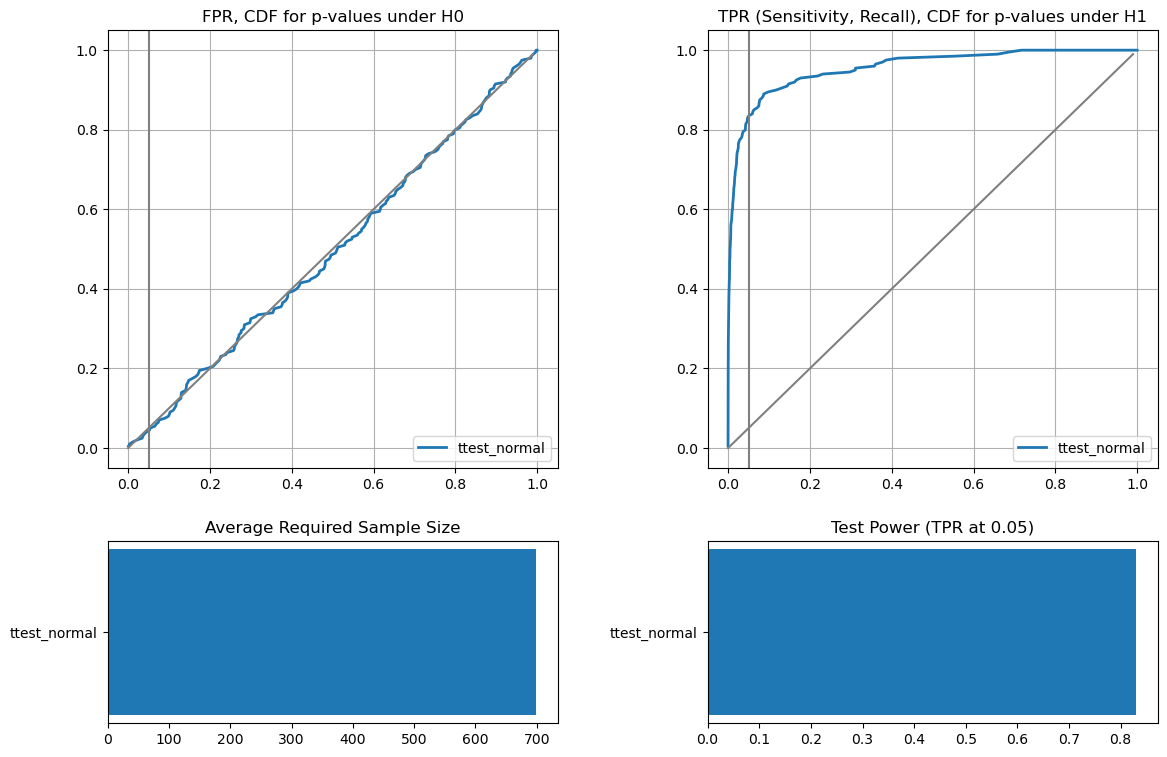

In [18]:
# Plotting results: Normal
# Heuristic not included in results due to lacking scientific basis for it to work.
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    )
}
_ = plot_summary(test_res)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

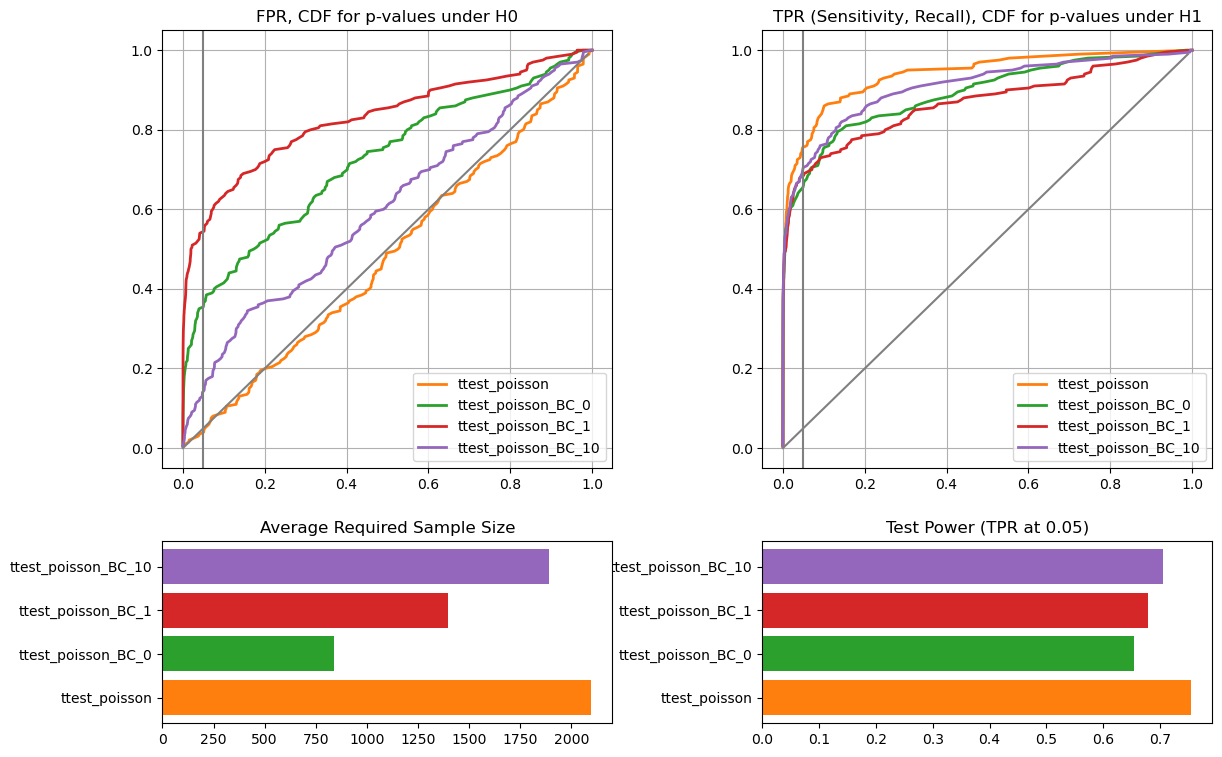

In [19]:
# Plotting results: Poisson BC
test_res = {
    "ttest_poisson": (
        respbc[0],
        respbc[1],
        respbc[2],
        colors[1]
    ),
    "ttest_poisson_BC_0": (
        resp0bc[0],
        resp0bc[1],
        resp0bc[2],
        colors[2]
    ),
    "ttest_poisson_BC_1": (
        resp1bc[0],
        resp1bc[1],
        resp1bc[2],
        colors[3]
    ),
    "ttest_poisson_BC_10": (
        resp10bc[0],
        resp10bc[1],
        resp10bc[2],
        colors[4]
    )
}
_ = plot_summary(test_res)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

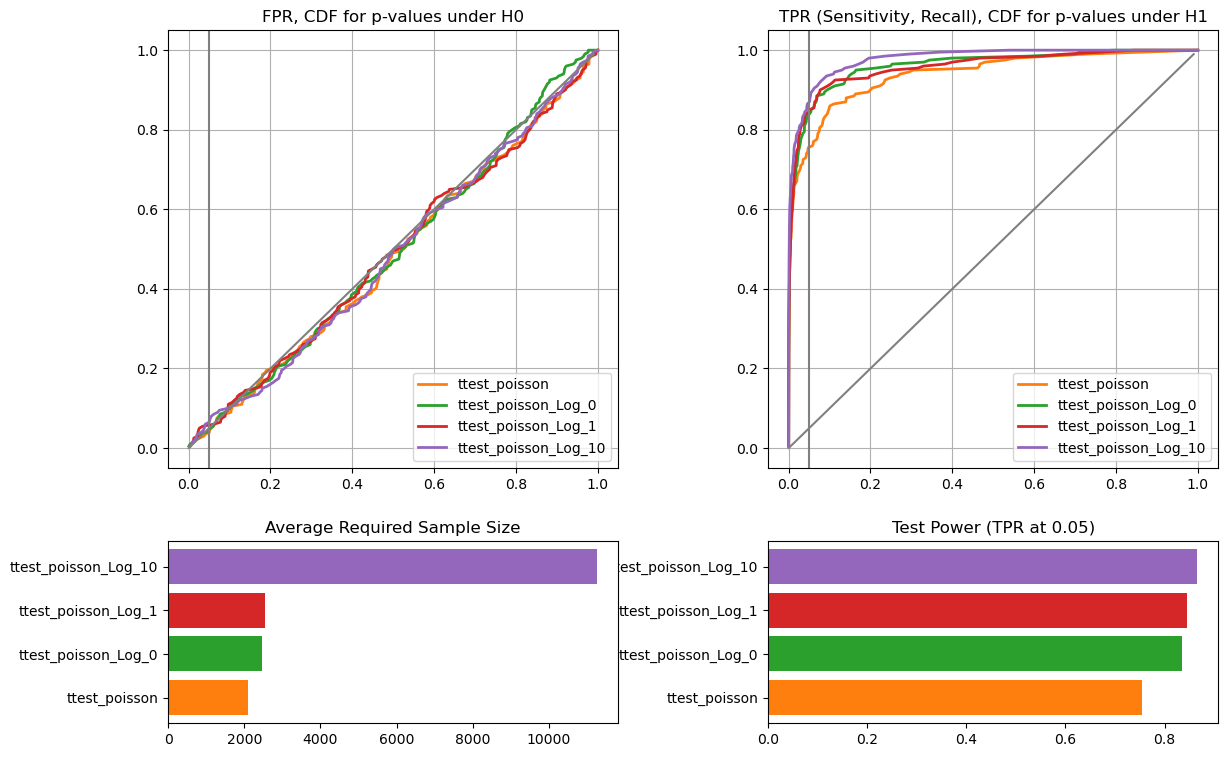

In [20]:
# Plotting results: Poisson Log
test_res = {
    "ttest_poisson": (
        resplog[0],
        resplog[1],
        resplog[2],
        colors[1]
    ),
    "ttest_poisson_Log_0": (
        resp0log[0],
        resp0log[1],
        resp0log[2],
        colors[2]
    ),
    "ttest_poisson_Log_1": (
        resp1log[0],
        resp1log[1],
        resp1log[2],
        colors[3]
    ),
    "ttest_poisson_Log_10": (
        resp10log[0],
        resp10log[1],
        resp10log[2],
        colors[4]
    )
}
_ = plot_summary(test_res)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

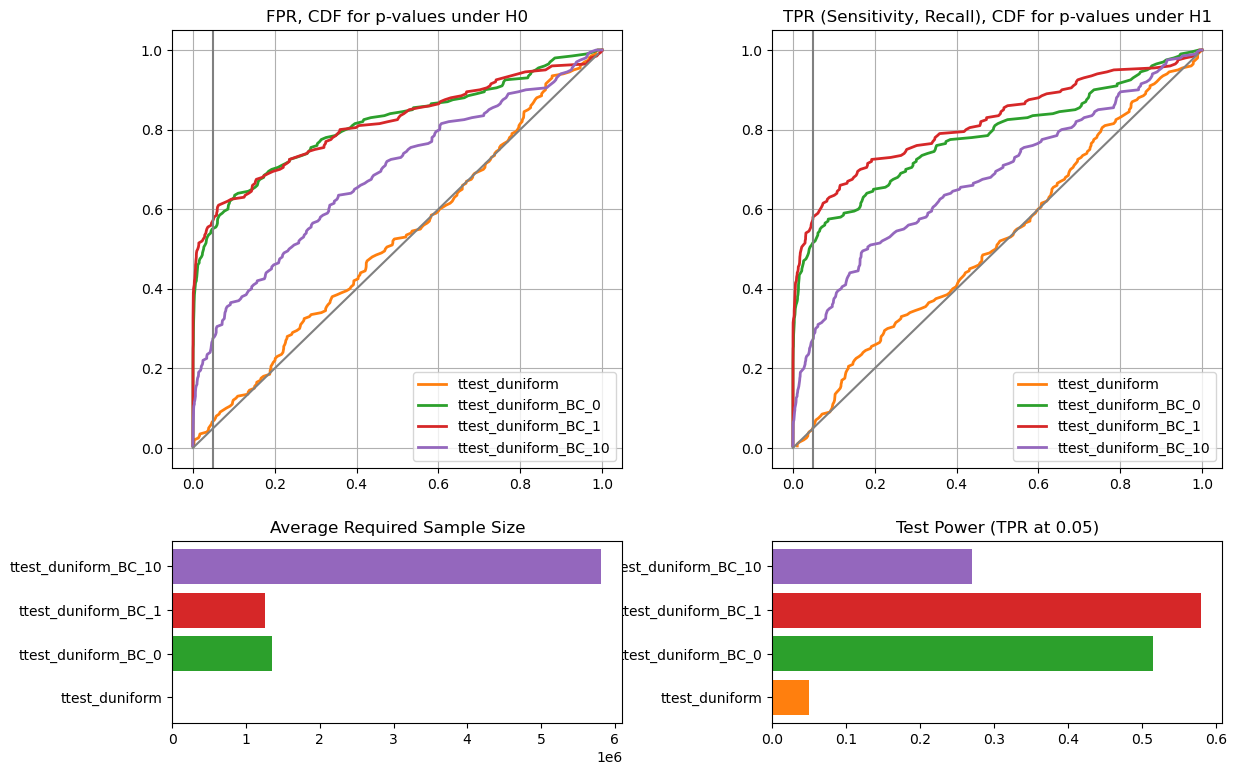

In [21]:
# Plotting results: Discrete Uniform BC
test_res = {
    "ttest_duniform": (
        resdubc[0],
        resdubc[1],
        resdubc[2],
        colors[1]
    ),
    "ttest_duniform_BC_0": (
        resdu0bc[0],
        resdu0bc[1],
        resdu0bc[2],
        colors[2]
    ),
    "ttest_duniform_BC_1": (
        resdu1bc[0],
        resdu1bc[1],
        resdu1bc[2],
        colors[3]
    ),
    "ttest_duniform_BC_10": (
        resdu10bc[0],
        resdu10bc[1],
        resdu10bc[2],
        colors[4]
    )
}
_ = plot_summary(test_res)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

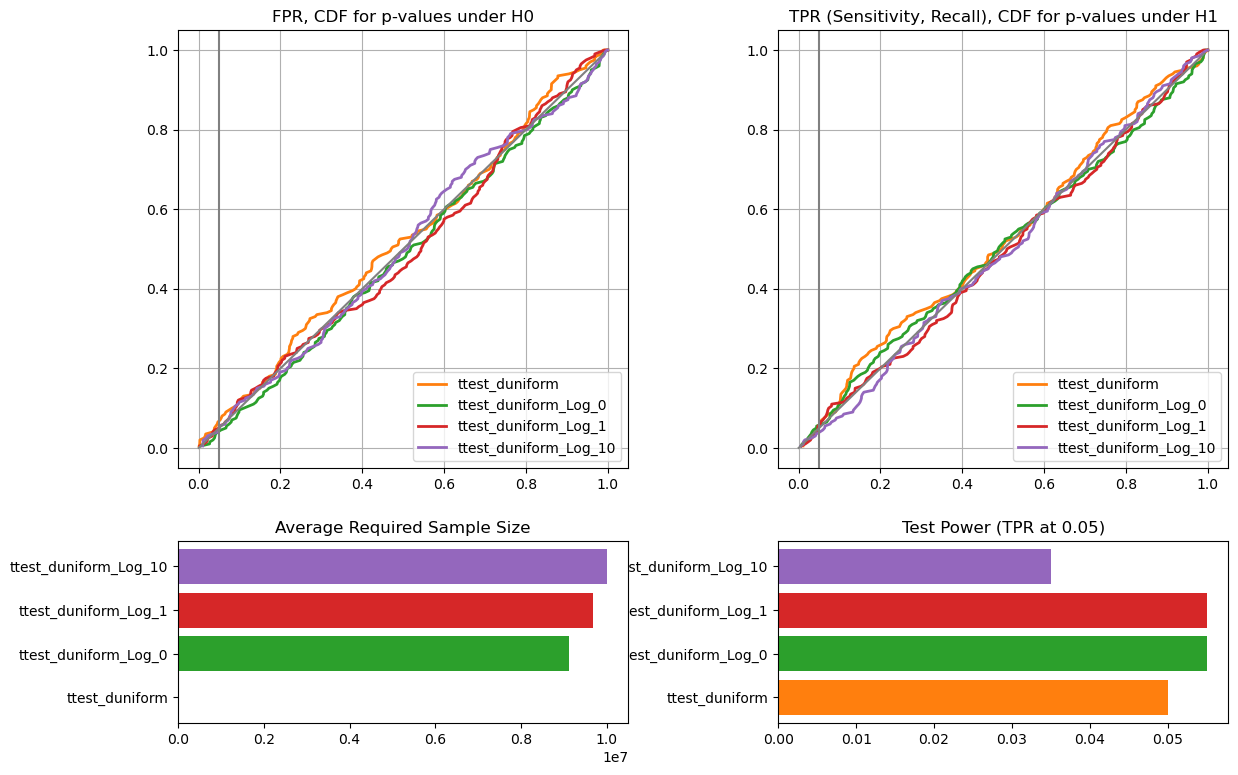

In [22]:
# Plotting results: Discrete Uniform Log
test_res = {
    "ttest_duniform": (
        resdulog[0],
        resdulog[1],
        resdulog[2],
        colors[1]
    ),
    "ttest_duniform_Log_0": (
        resdu0log[0],
        resdu0log[1],
        resdu0log[2],
        colors[2]
    ),
    "ttest_duniform_Log_1": (
        resdu1log[0],
        resdu1log[1],
        resdu1log[2],
        colors[3]
    ),
    "ttest_duniform_Log_10": (
        resdu10log[0],
        resdu10log[1],
        resdu10log[2],
        colors[4]
    )
}
_ = plot_summary(test_res)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

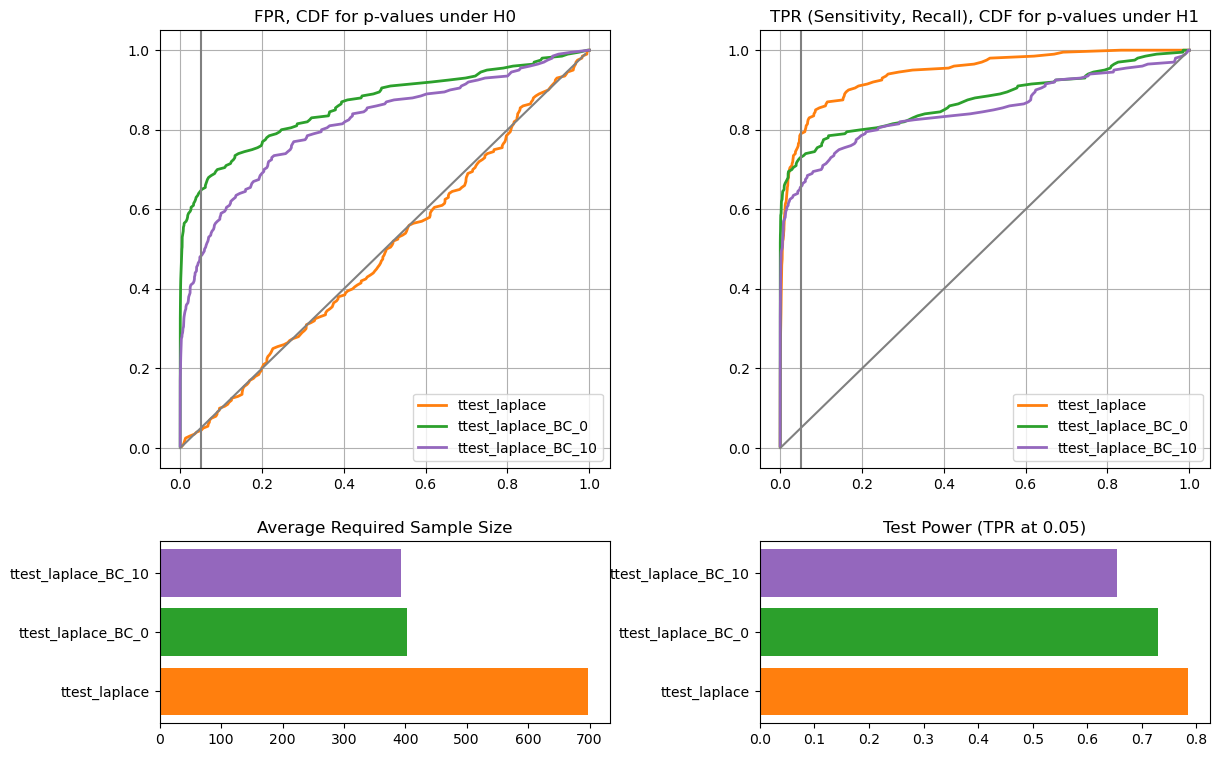

In [250]:
# Plotting results: Laplace BC
test_res = {
    "ttest_laplace": (
        reslabc[0],
        reslabc[1],
        reslabc[2],
        colors[1]
    ),
    "ttest_laplace_BC_0": (
        resla0bc[0],
        resla0bc[1],
        resla0bc[2],
        colors[2]
    ),
    #"ttest_laplace_BC_1": (
    #    resla1bc[0],
    #    resla1bc[1],
    #    resla1bc[2],
    #    colors[3]
    #),
    "ttest_laplace_BC_10": (
        resla10bc[0],
        resla10bc[1],
        resla10bc[2],
        colors[4]
    )
}
_ = plot_summary(test_res)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

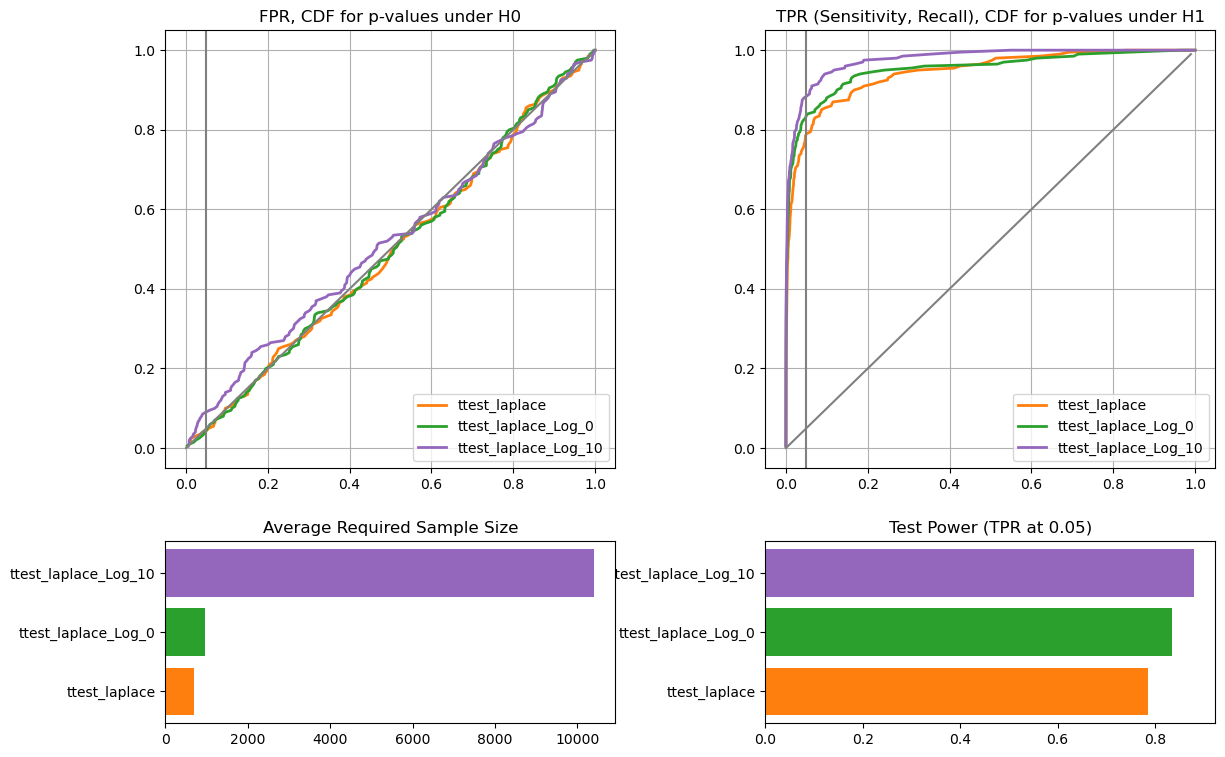

In [252]:
# Plotting results: Laplace Log
test_res = {
    "ttest_laplace": (
        reslalog[0],
        reslalog[1],
        reslalog[2],
        colors[1]
    ),
    "ttest_laplace_Log_0": (
        resla0log[0],
        resla0log[1],
        resla0log[2],
        colors[2]
    ),
    #"ttest_laplace_Log_1": (
    #    resla1log[0],
    #    resla1log[1],
    #    resla1log[2],
    #    colors[3]
    #),
    "ttest_laplace_Log_10": (
        resla10log[0],
        resla10log[1],
        resla10log[2],
        colors[4]
    )
}
_ = plot_summary(test_res)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

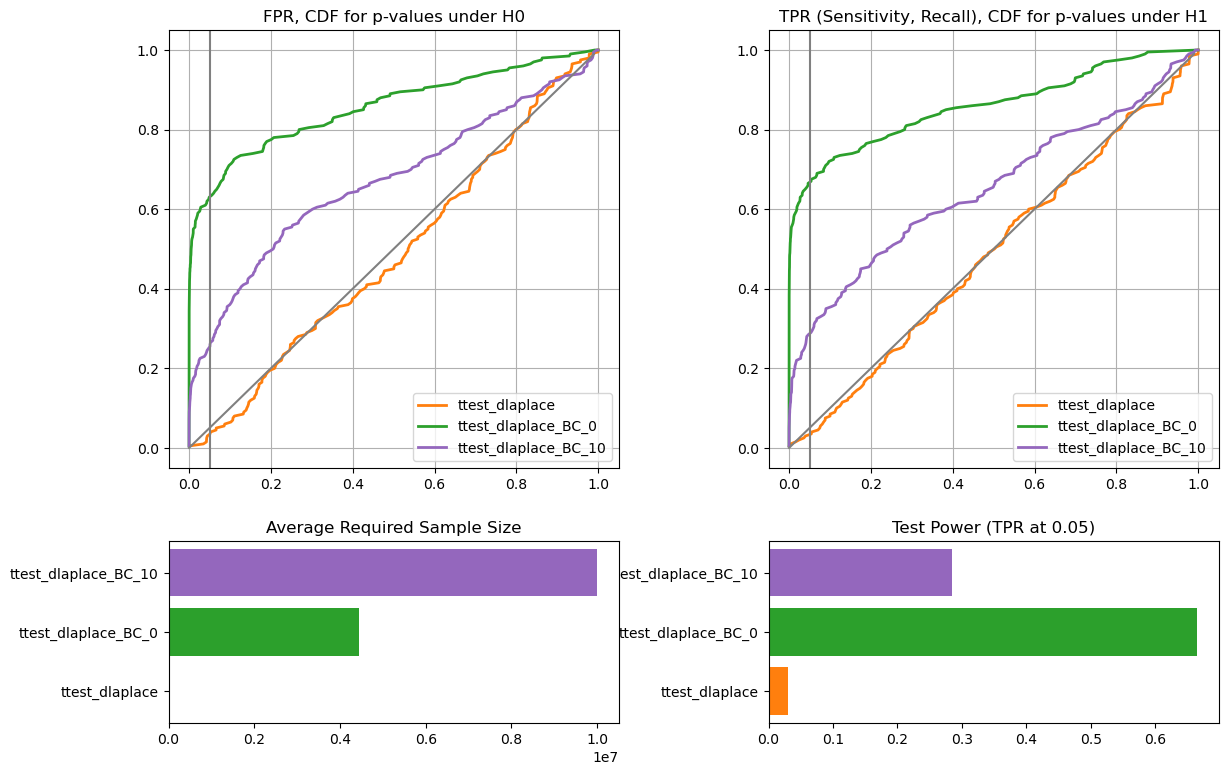

In [253]:
# Plotting results: Dlaplace BC
test_res = {
    "ttest_dlaplace": (
        resdlabc[0],
        resdlabc[1],
        resdlabc[2],
        colors[1]
    ),
    "ttest_dlaplace_BC_0": (
        resdla0bc[0],
        resdla0bc[1],
        resdla0bc[2],
        colors[2]
    ),
    #"ttest_dlaplace_BC_1": (
    #    resdla1bc[0],
    #    resdla1bc[1],
    #    resdla1bc[2],
    #    colors[3]
    #),
    "ttest_dlaplace_BC_10": (
        resdla10bc[0],
        resdla10bc[1],
        resdla10bc[2],
        colors[4]
    )
}
_ = plot_summary(test_res)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

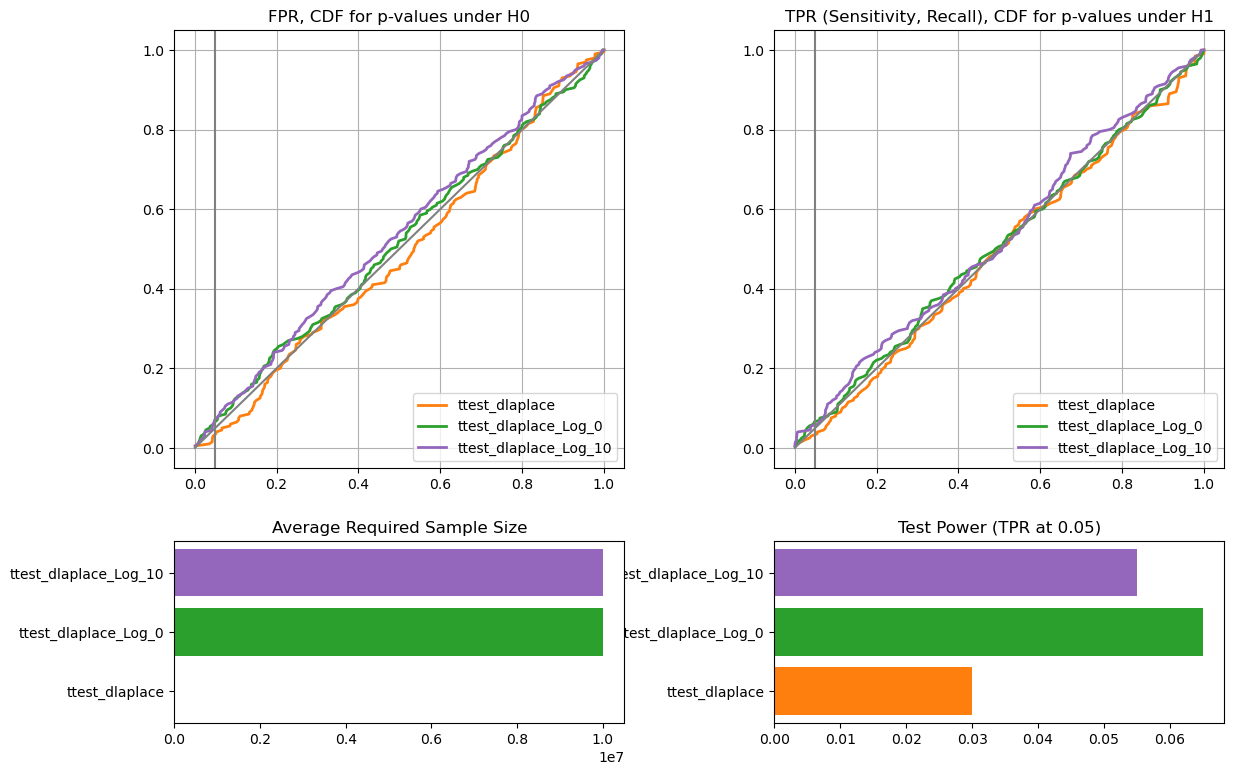

In [243]:
# Plotting results: Dlaplace Log
test_res = {
    "ttest_dlaplace": (
        resdlalog[0],
        resdlalog[1],
        resdlalog[2],
        colors[1]
    ),
    "ttest_dlaplace_Log_0": (
        resdla0log[0],
        resdla0log[1],
        resdla0log[2],
        colors[2]
    ),
    #"ttest_dlaplace_Log_1": (
    #    resdla1log[0],
    #    resdla1log[1],
    #    resdla1log[2],
    #    colors[3]
    #),
    "ttest_dlaplace_Log_10": (
        resdla10log[0],
        resdla10log[1],
        resdla10log[2],
        colors[4]
    )
}
_ = plot_summary(test_res)

In [27]:
# Now higher limits.

In [28]:
# Higher mean:
mean = 15
var = np.sqrt(mean)

nobs = approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 3.876722786861402


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

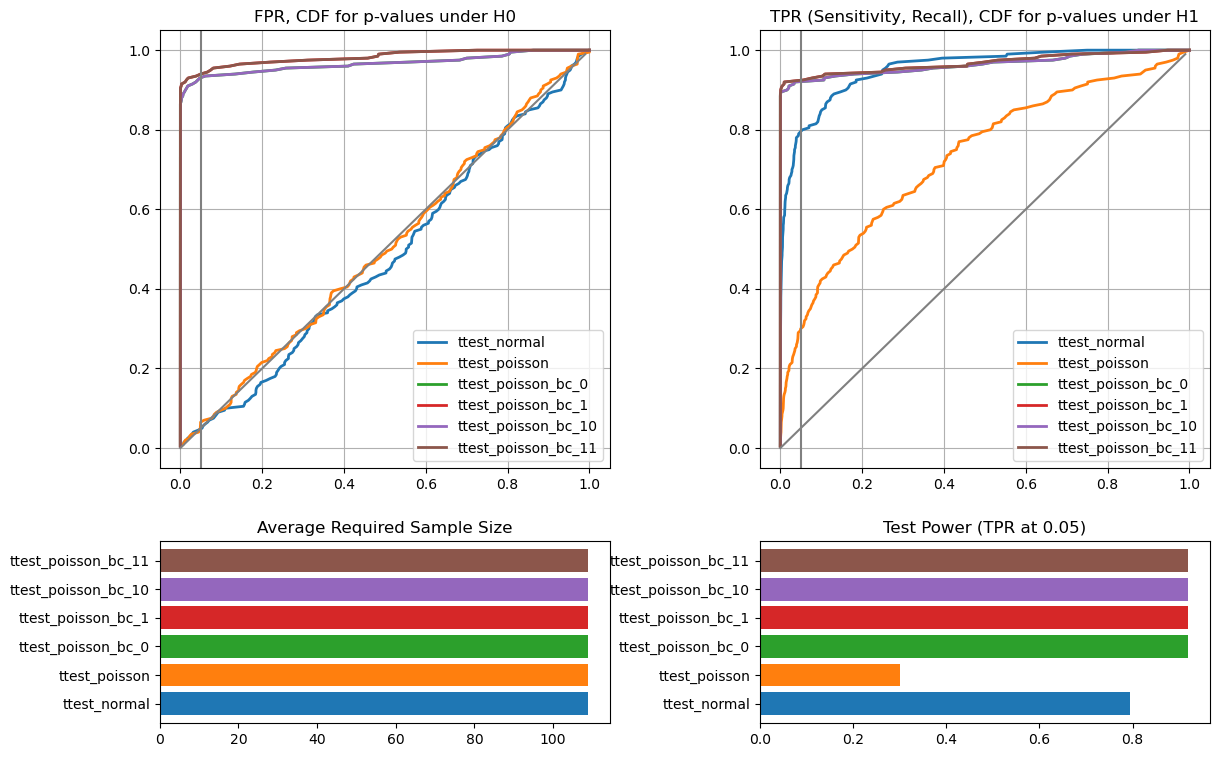

In [29]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_bc_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_bc_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_bc_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [30]:
# Higher mean:
mean = 15
var = np.sqrt(mean)

nobs = 0 #approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 3.876722786861402
variance = 14.966432360764003
mde = 0.039673937950855394
variance = 2.5940684695454452
mde = 0.038981886314637997
variance = 2.1552798710713614
mde = 0.039673937950855394
variance = 2.5940684695454452
mde = 0.044796652824527224
variance = 2.1552798710713614


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

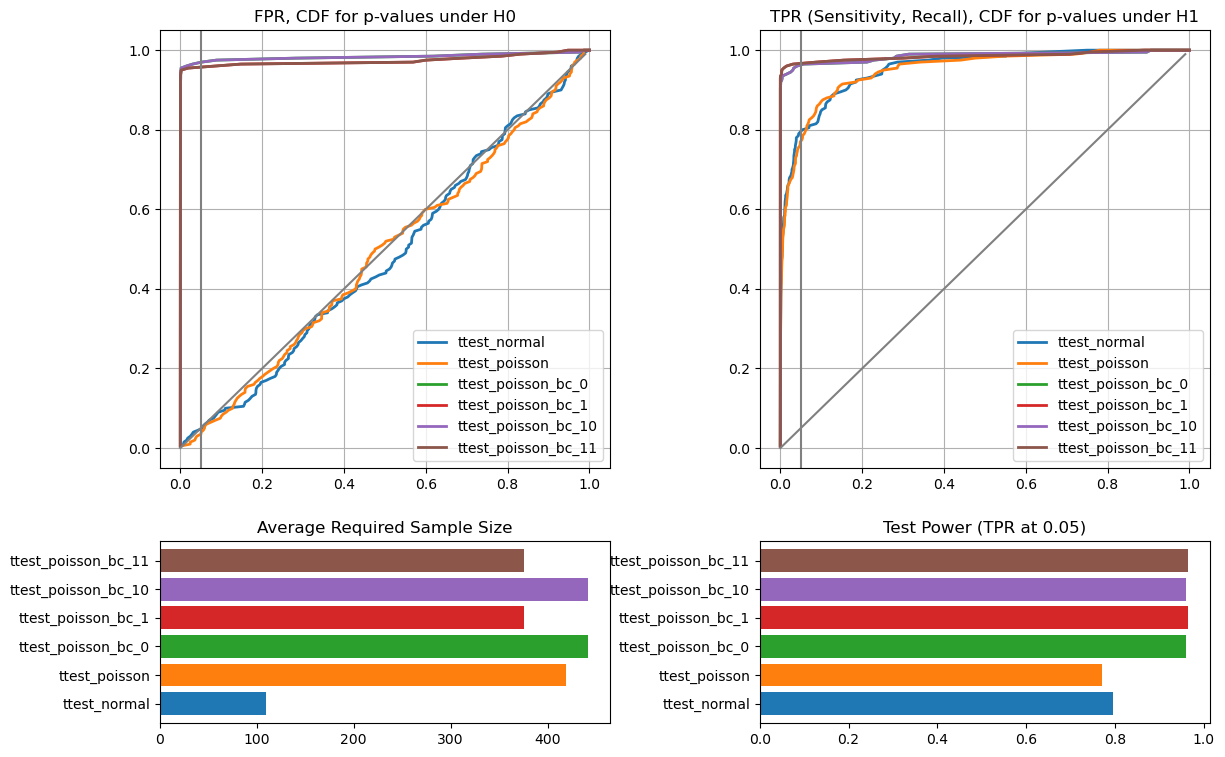

In [31]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_bc_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_bc_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_bc_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [32]:
# Higher mean:
mean = 15
var = np.sqrt(mean)

nobs = approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 3.876722786861402


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

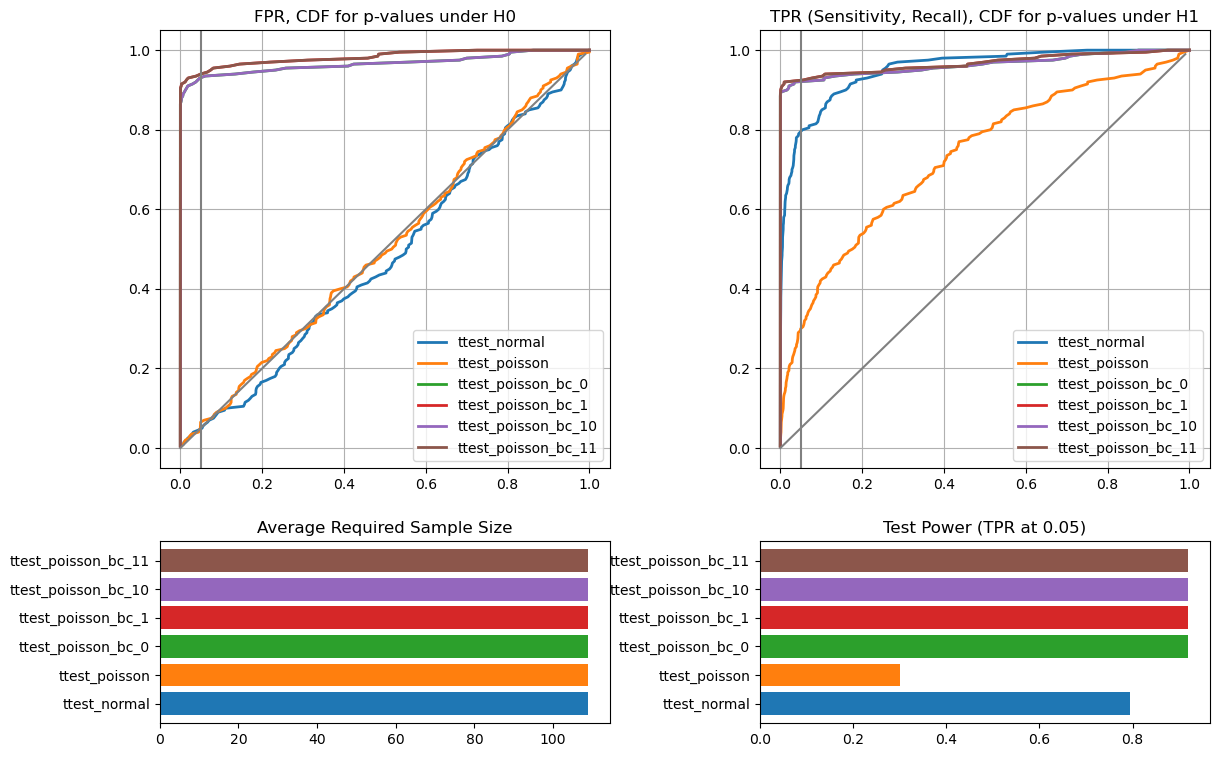

In [33]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_bc_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_bc_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_bc_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [34]:
# Higher mean:
mean = 15
var = np.sqrt(mean)

nobs = 0 #approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 3.876722786861402
variance = 14.966432360764003
mde = 0.018679307995438293
variance = 0.0746774047665572
mde = 0.01697323887391731
variance = 0.06424869944563119
mde = 0.018679307995438293
variance = 0.0746774047665572
mde = 0.026716968831260436
variance = 0.06424869944563119


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

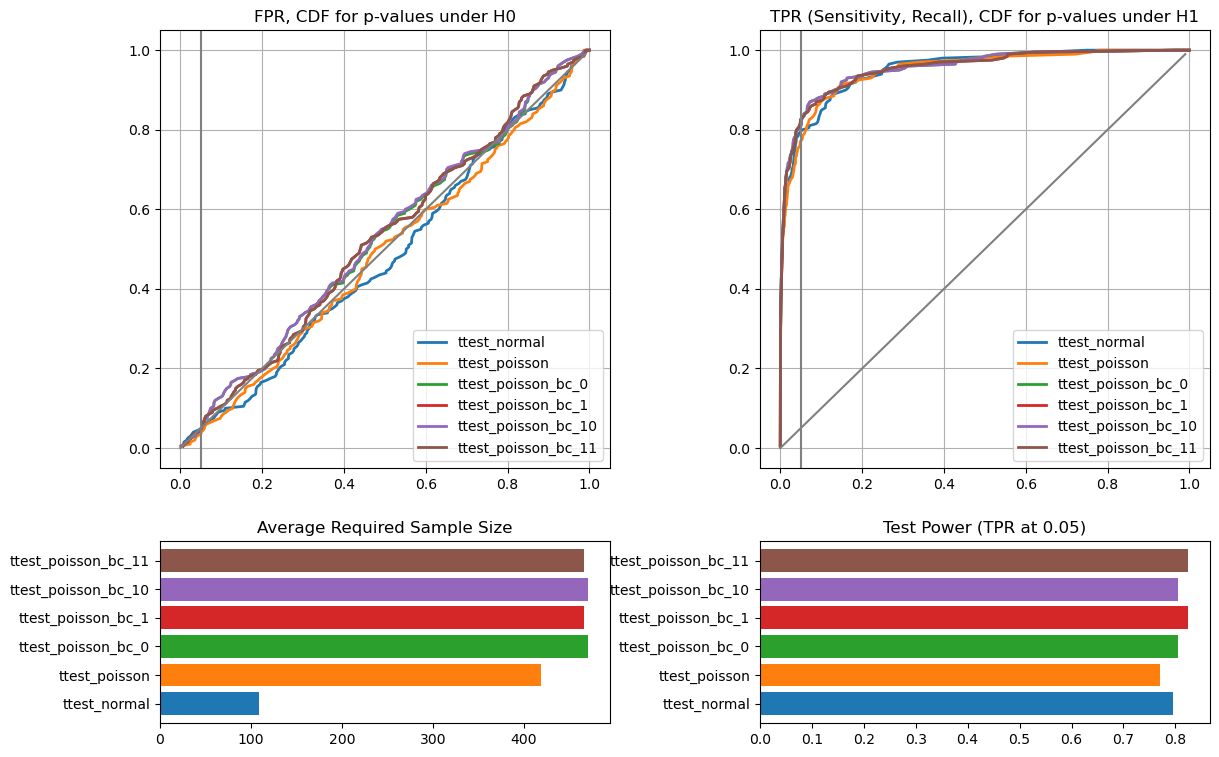

In [35]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_bc_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_bc_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_bc_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [112]:
dist = poisson
trans = log
mean = 1
var = 1
mde = 0.01
chosen_seed = 42
seed_change = 1
nobs = 0

# Poisson Log
reslog = complete_test(dist, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
res0log = complete_test(dist, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
res1log = complete_test(dist, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
res10log = complete_test(dist, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
#resp11log = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 1.0019469795509997
mde = 0.017956733139762565
variance = 0.15223241334407678
mde = 0.008670743202202548
variance = 0.23943578928459877
mde = -0.010477931797584846
variance = 127.20011202542302


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

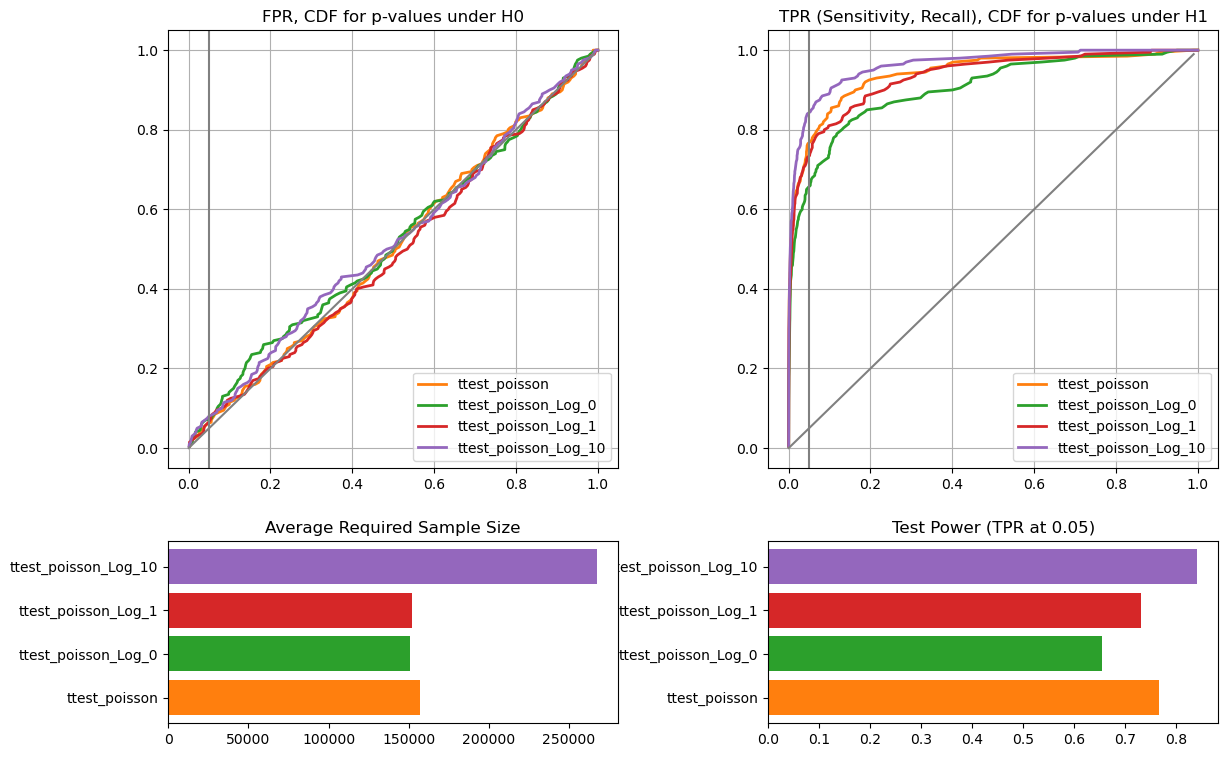

In [113]:
# Plotting results: Dlaplace Log
test_res = {
    "ttest_poisson": (
        reslog[0],
        reslog[1],
        reslog[2],
        colors[1]
    ),
    "ttest_poisson_Log_0": (
        res0log[0],
        res0log[1],
        res0log[2],
        colors[2]
    ),
    "ttest_poisson_Log_1": (
        res1log[0],
        res1log[1],
        res1log[2],
        colors[3]
    ),
    "ttest_poisson_Log_10": (
        res10log[0],
        res10log[1],
        res10log[2],
        colors[4]
    )
}
_ = plot_summary(test_res)

In [114]:
dist = laplace
trans = log
mean = 1
var = 1
nobs = 0
mde = 0.01

# Poisson Log
reslog = complete_test(dist, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
res0log = complete_test(dist, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
#res1log = complete_test(dist, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
res10log = complete_test(dist, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
#resp11log = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 1.0003143290598897
mde = -0.31007107326364436
variance = 0.5895665991093316
mde = -0.015510706043047679
variance = 56.97950695185967


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

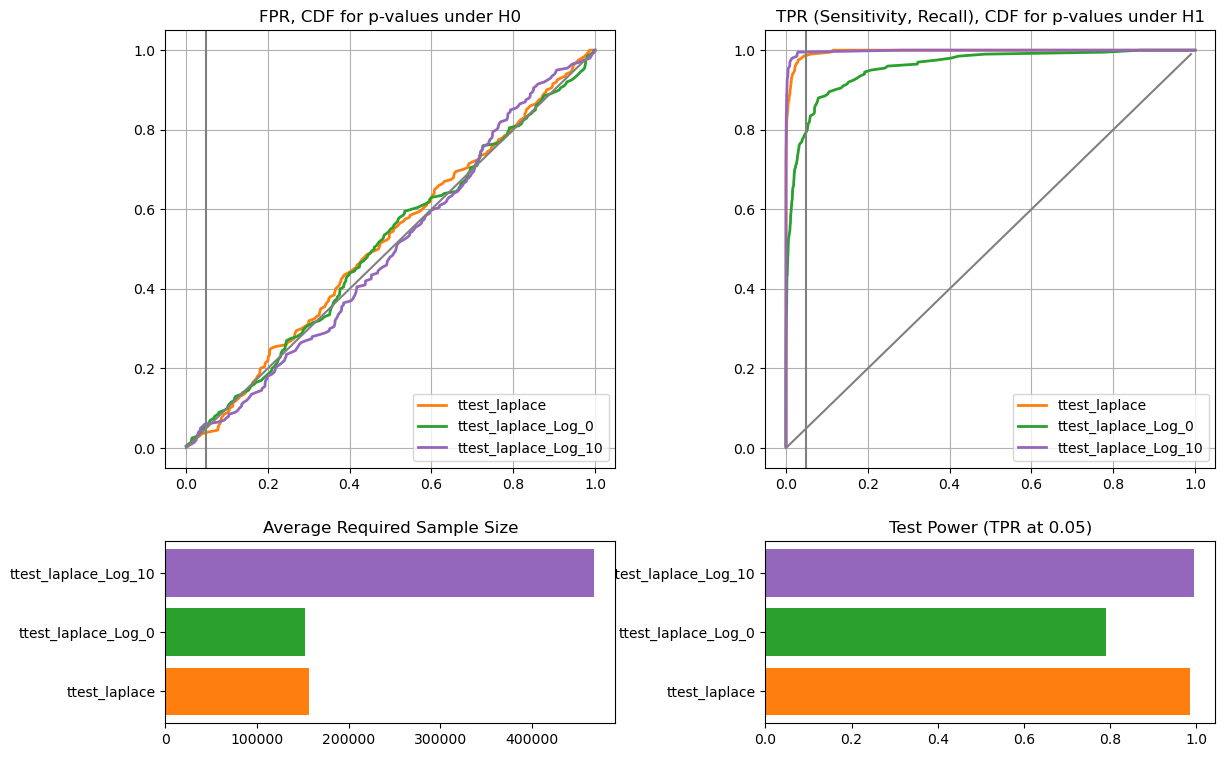

In [115]:
# Plotting results: Dlaplace Log
test_res = {
    "ttest_laplace": (
        reslog[0],
        reslog[1],
        reslog[2],
        colors[1]
    ),
    "ttest_laplace_Log_0": (
        res0log[0],
        res0log[1],
        res0log[2],
        colors[2]
    ),
    #"ttest_laplace_Log_1": (
    #    res1log[0],
    #    res1log[1],
    #    res1log[2],
    #    colors[3]
    #),
    "ttest_laplace_Log_10": (
        res10log[0],
        res10log[1],
        res10log[2],
        colors[4]
    )
}
_ = plot_summary(test_res)

In [119]:
dist = dlaplace
trans = log
mean = 1
var = 1
nobs = 0
mde = 0.01

# Poisson Log
reslog = complete_test(dist, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
res0log = complete_test(dist, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
#res1log = complete_test(dist, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
res10log = complete_test(dist, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
#resp11log = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 1.0697685683509999
mde = 0.01528165115455442
variance = 0.13525435715116785
mde = -0.016118239143865756
variance = 100.95252687145198


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

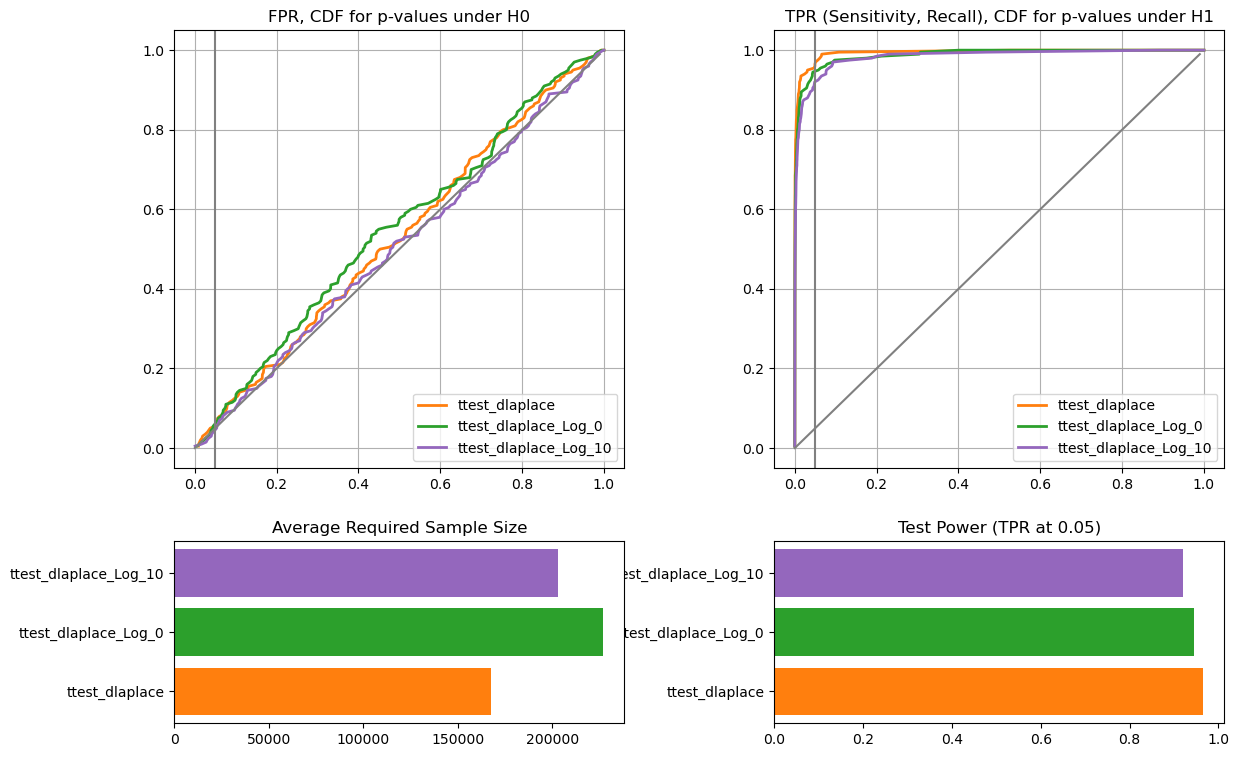

In [120]:
# Plotting results: Dlaplace Log
test_res = {
    "ttest_dlaplace": (
        reslog[0],
        reslog[1],
        reslog[2],
        colors[1]
    ),
    "ttest_dlaplace_Log_0": (
        res0log[0],
        res0log[1],
        res0log[2],
        colors[2]
    ),
    #"ttest_dlaplace_Log_1": (
    #    res1log[0],
    #    res1log[1],
    #    res1log[2],
    #    colors[3]
    #),
    "ttest_dlaplace_Log_10": (
        res10log[0],
        res10log[1],
        res10log[2],
        colors[4]
    )
}
_ = plot_summary(test_res)

In [80]:
# But, no modifications should be valid here as well!!!

nobs = approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
respb00 = complete_test(poisson, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
respl00 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 1.0009655194251346


/tmp/ipykernel_14068/3779698551.py:81: RuntimeWarning: divide by zero encountered in log
  a_data = np.log(a_data)
/tmp/ipykernel_14068/3779698551.py:81: RuntimeWarning: invalid value encountered in log
  a_data = np.log(a_data)
/tmp/ipykernel_14068/3779698551.py:82: RuntimeWarning: divide by zero encountered in log
  aa_data = np.log(aa_data)
/tmp/ipykernel_14068/3779698551.py:82: RuntimeWarning: invalid value encountered in log
  aa_data = np.log(aa_data)
/tmp/ipykernel_14068/3779698551.py:83: RuntimeWarning: divide by zero encountered in log
  ab_data = np.log(ab_data)
/tmp/ipykernel_14068/3779698551.py:83: RuntimeWarning: invalid value encountered in log
  ab_data = np.log(ab_data)


KeyboardInterrupt: 

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

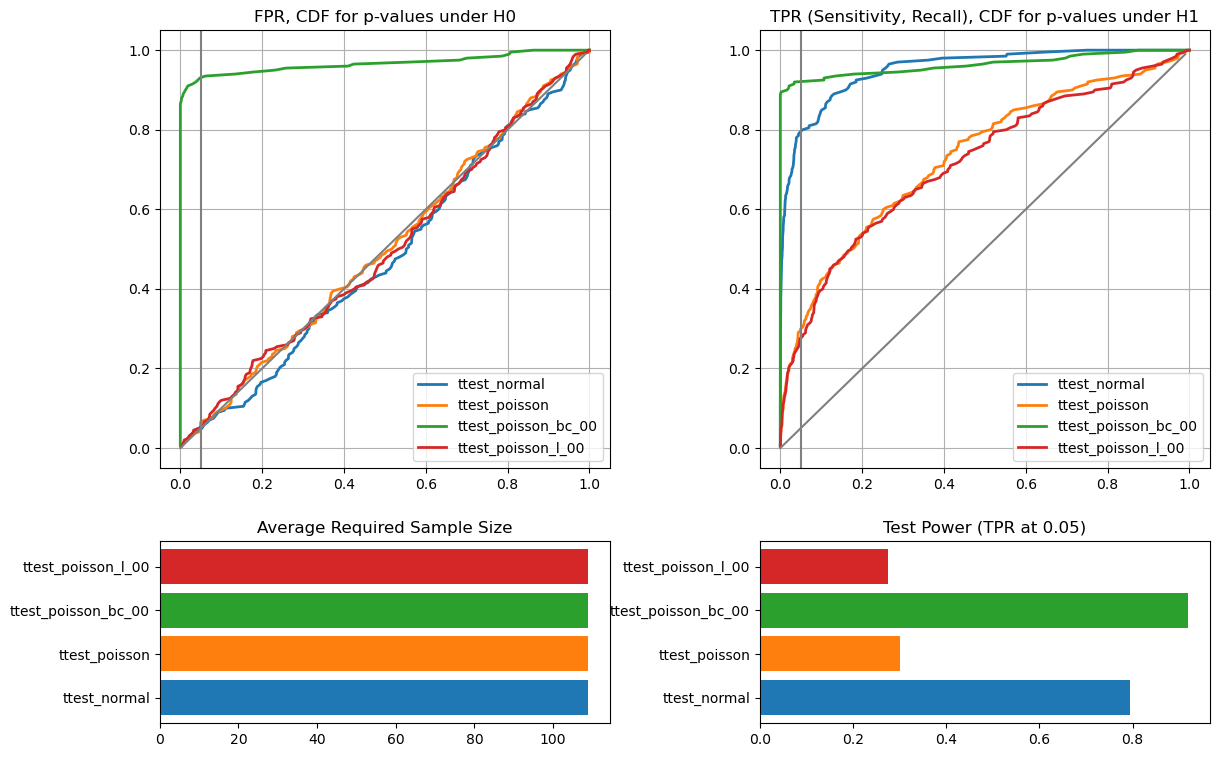

In [ ]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_00": (
        respb00[0],
        respb00[1],
        respb00[2],
        colors[2]
    ),
    "ttest_poisson_l_00": (
        respl00[0],
        respl00[1],
        respl00[2],
        colors[3]
    )
}
_ = plot_summary(test_res)

In [38]:
# But, no modifications should be valid here as well!!!

nobs = 0 #approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
respb00 = complete_test(poisson, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
respl00 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 3.876722786861402
variance = 14.966432360764003
mde = 0.039673937950855394
variance = 2.5940684695454452
mde = 0.018679307995438293
variance = 0.0746774047665572


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

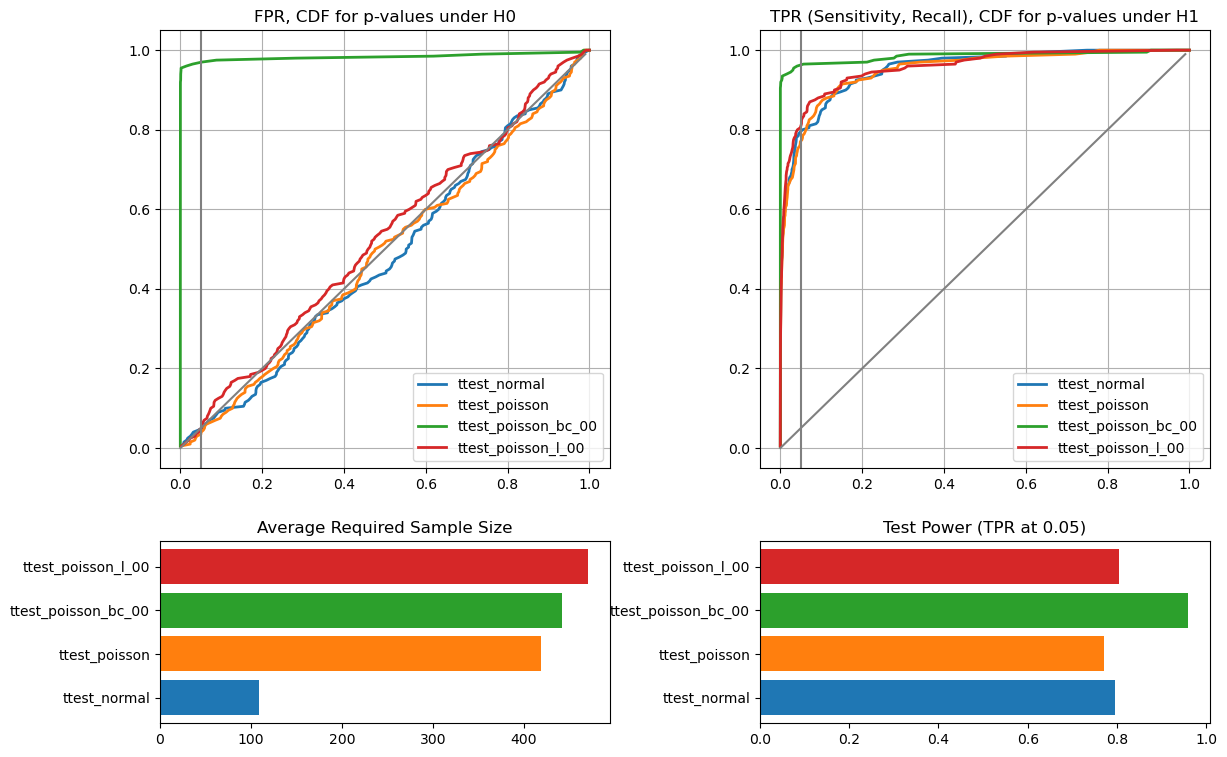

In [39]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_00": (
        respb00[0],
        respb00[1],
        respb00[2],
        colors[2]
    ),
    "ttest_poisson_l_00": (
        respl00[0],
        respl00[1],
        respl00[2],
        colors[3]
    )
}
_ = plot_summary(test_res)

In [40]:
# Approximation with better MDE and bc log for mean = 3 and var = 1
# Lower limits
mean = 3
var = 1
mde = 0.01

# Now the same but with log instead
nobs = approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)


variance = 1.0009655194251348


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

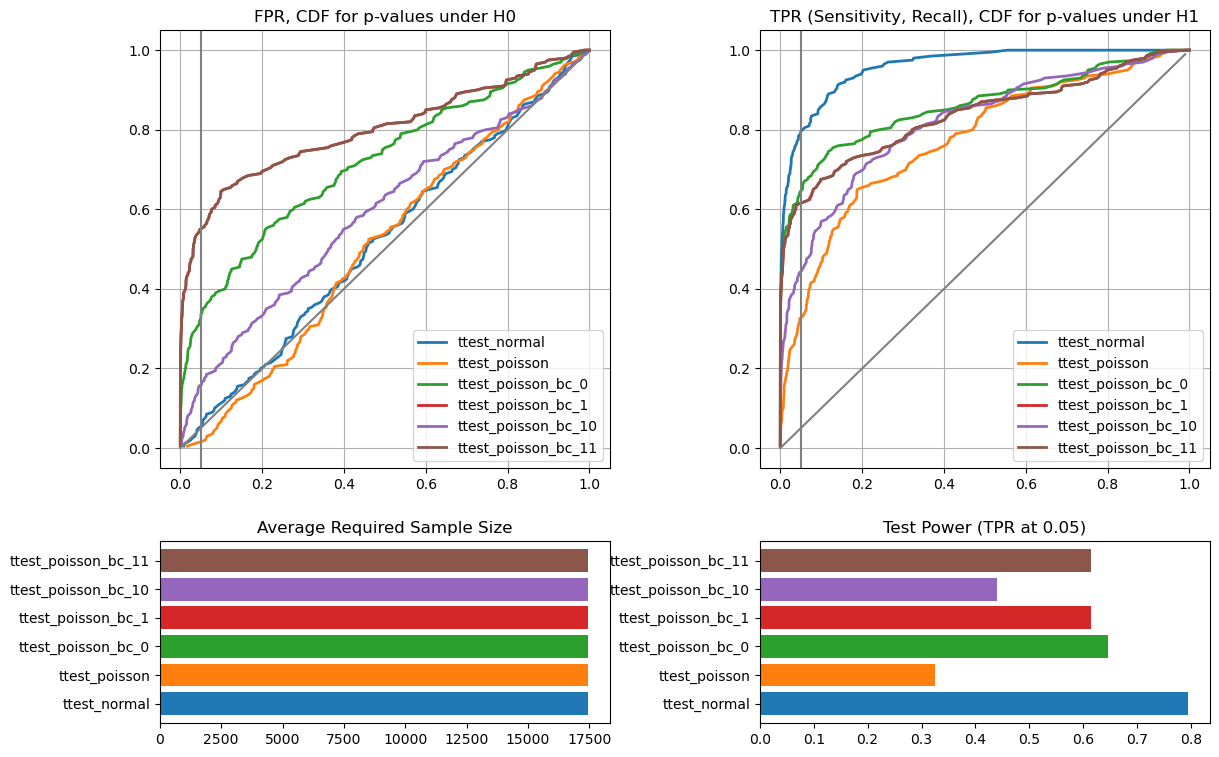

In [41]:
# First graph, + mde at fixed nobs for all log methods
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_bc_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_bc_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_bc_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [42]:
nobs = 0 #Now they approximate themselves
resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 1.0009655194251348
variance = 2.9986781048159994
mde = 0.015906198626388344
variance = 0.5740692294742034
mde = 0.008172029013297792
variance = 0.7980509063531095
mde = 0.017286747640302778
variance = 1.341325640390925
mde = 0.017053886936437966
variance = 0.7980509063531095


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

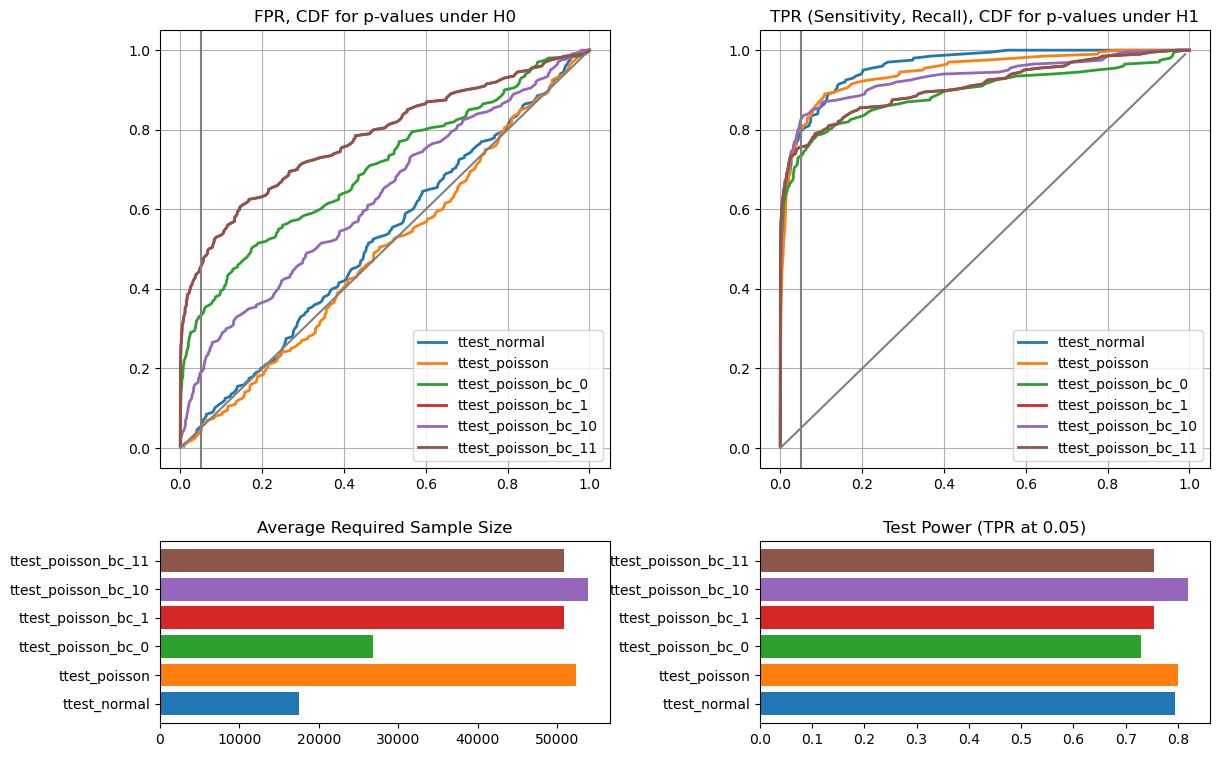

In [43]:
# First graph, + mde at fixed nobs for all log methods
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_bc_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_bc_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_bc_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [44]:
# Now the same but with log:

nobs = approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 1.0009655194251348


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

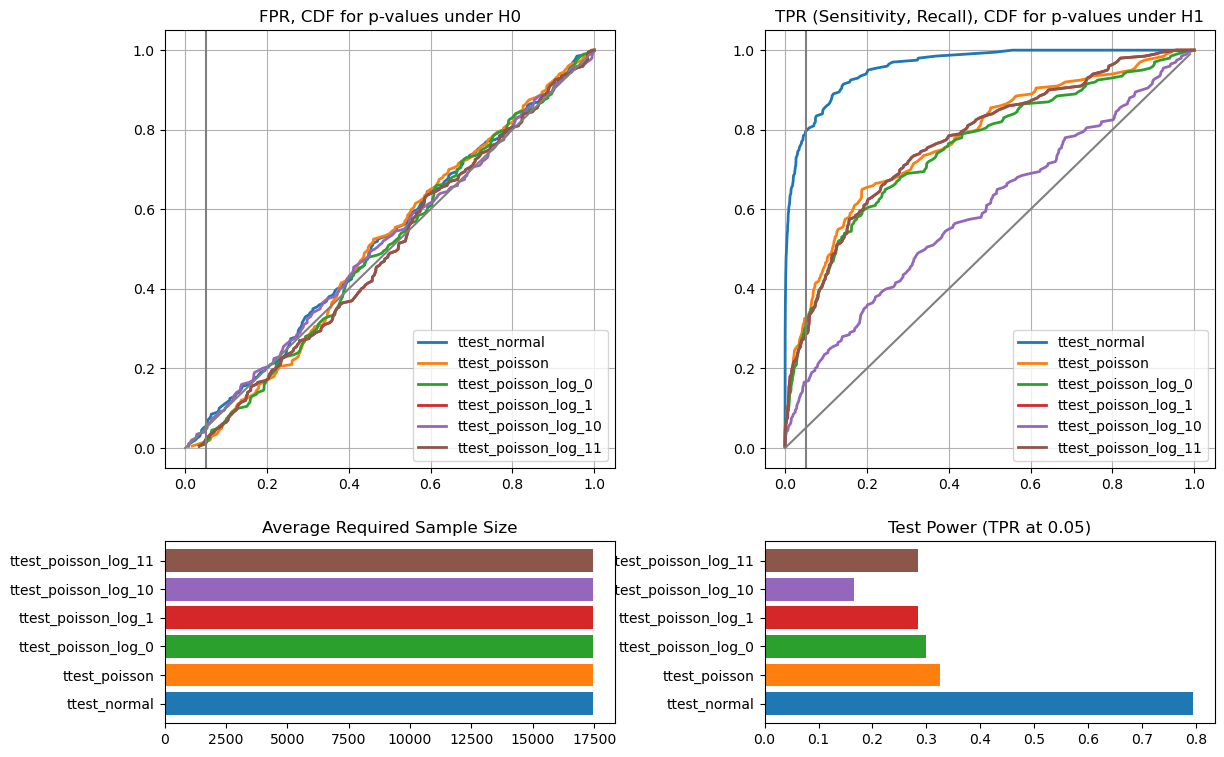

In [45]:
# First graph, + mde at fixed nobs for all log methods
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_log_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_log_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_log_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_log_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [46]:
# Now with own approximated log:

# Now the same but with log:

nobs = 0

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 1.0009655194251348
variance = 2.9986781048159994
mde = 0.00911518892246972
variance = 0.3488885985562106
mde = 0.005550025763173986
variance = 0.2346268343190447
mde = -0.20548123393303253
variance = 27.570660705451694
mde = 0.025276090767041928
variance = 0.2346268343190447


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

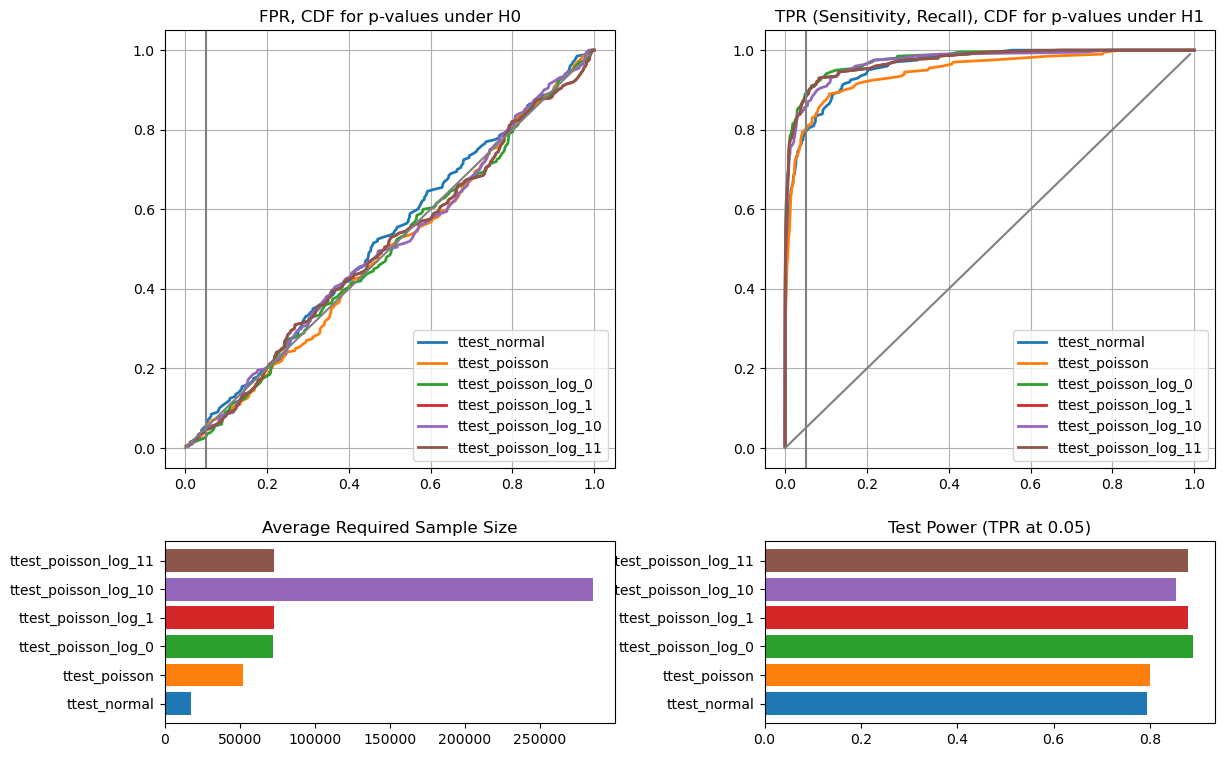

In [47]:
# First graph, + mde at fixed nobs for all log methods
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_log_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_log_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_log_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_log_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [48]:
# Absolutely most difficult situation:

mean = 1
var = 1
mde = 0.01

nobs = approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 1.0009655194251346


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

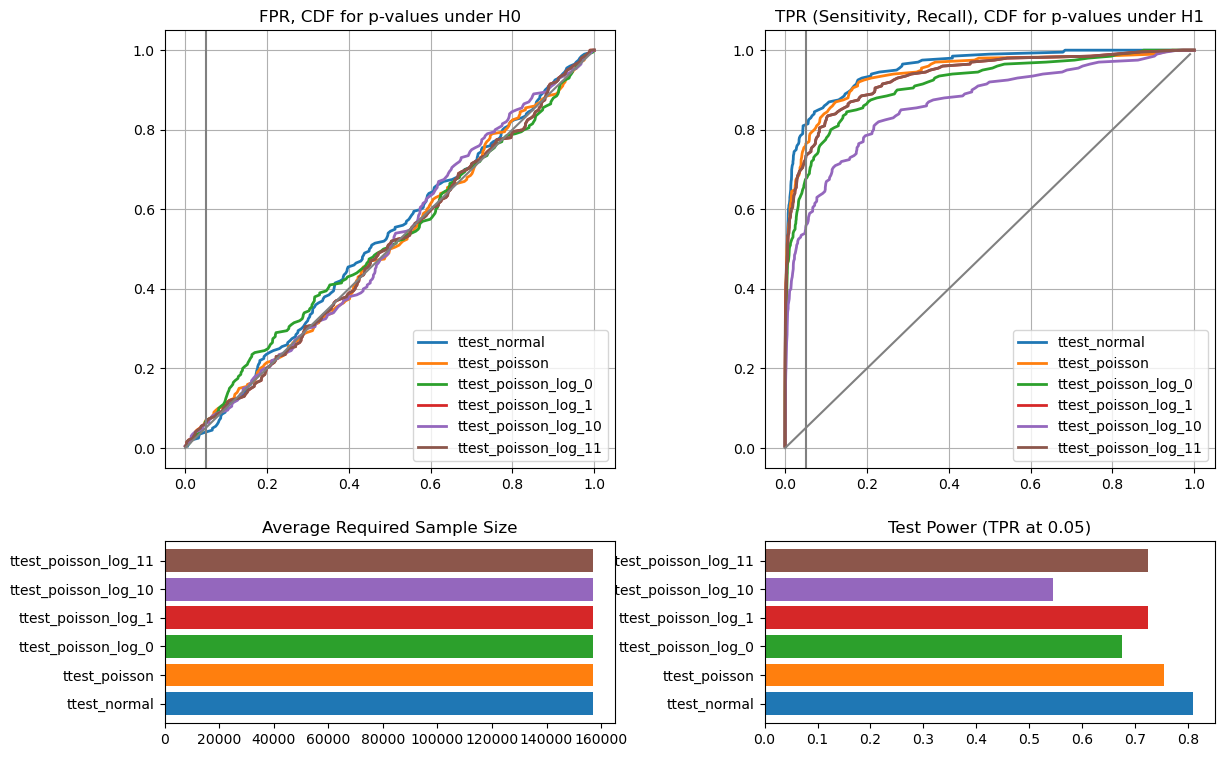

In [49]:
# First graph, + mde at fixed nobs for all log methods
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_log_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_log_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_log_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_log_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [50]:
nobs = 0

n_exps = 200

mean = 1
var = 1

mde = 0.01

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 1.0009655194251346
variance = 1.0019469795509997
mde = 0.017956733139762565
variance = 0.15223241334407678
mde = 0.008670743202202548
variance = 0.23943578928459877
mde = -0.010477931797584846
variance = 127.20011202542302
mde = -0.011640179552197469
variance = 0.23943578928459877


In [51]:
# MDE-limits

In [52]:
nobs = 0

mean = 2
var = 1
mde = 0.05

n_exps = 200

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 1.0009655194251346
variance = 2.0005093243159995
mde = 0.06308634827086075
variance = 0.31186416483377644
mde = 0.03500304085518041
variance = 0.26263002762686405
mde = -0.13356876646772334
variance = 66.14198662177292
mde = -1.5559913278344129
variance = 0.2626300276268641


In [53]:
mde = 0.04

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 1.0009655194251346
variance = 2.0005093243159995
mde = 0.050223074530226314
variance = 0.3119023395499173
mde = 0.028123791790609972
variance = 0.2627484839827406
mde = -0.10980321800276072
variance = 66.18360317011702
mde = -1.2499007485414781
variance = 0.2627484839827406


In [54]:
mde = 0.03

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 1.0009655194251346
variance = 2.0005093243159995
mde = 0.03745720161436498
variance = 0.3119421267748641
mde = 0.021084159507312992
variance = 0.26279688962951187
mde = -0.08349599743878566
variance = 66.1952853439788
mde = -0.9365832612407701
variance = 0.26279688962951187


In [55]:
mde = 0.02

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 1.0009655194251346
variance = 2.0005093243159995
mde = 0.024298571819826007
variance = 0.3119542341613689
mde = 0.013806303312098233
variance = 0.2628241154410327
mde = -0.05595549427161472
variance = 66.19808998271242
mde = -0.6153458404233179
variance = 0.2628241154410327


In [56]:
mde = 0.01

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

variance = 1.0009655194251346
variance = 2.0005093243159995
mde = 0.011910602290484582
variance = 0.31190879392767684
mde = 0.006922925634238868
variance = 0.26285093567994167
mde = -0.029623796992259286
variance = 66.22870960969291
mde = -0.30656076536035093
variance = 0.2628509356799416


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

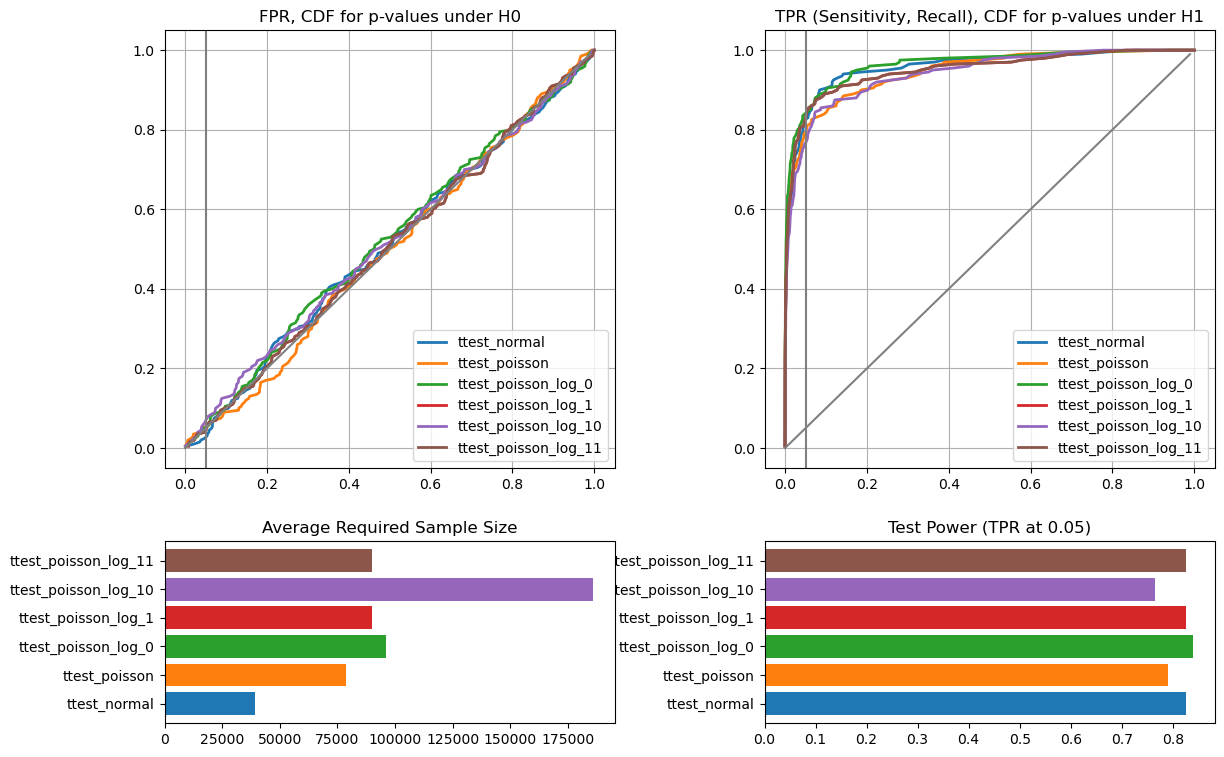

In [57]:
# First graph, + mde at fixed nobs for all log methods
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_log_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_log_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_log_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_log_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

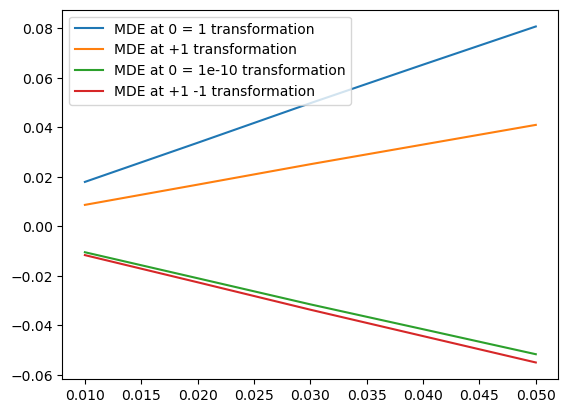

In [58]:
# Show relationship in MDE

x = [0.01,0.02,0.03,0.04,0.05]
y0 = [0.017956733139762565,0.03377721508490627,0.0497940781911947,0.06537310182200558,0.0808048467594187]
y1 = [0.008670743202202548,0.0168519543392199,0.025114899065481446,0.03306268190390825,0.04101358846518025]
y10 = [-0.010477931797584846, -0.020992254699001543, -0.03155246728905465, -0.04160826773207834, -0.05171469650507253]
y11 = [-0.011640179552197469,-0.02262606029584137,-0.033713303703857694, -0.04438862881270553 , -0.05505295871630684]
plt.plot(x, y0, label = "MDE at 0 = 1 transformation")
plt.plot(x, y1, label = "MDE at +1 transformation")
plt.plot(x, y10, label = "MDE at 0 = 1e-10 transformation")
plt.plot(x, y11, label = "MDE at +1 -1 transformation")
plt.legend()
plt.show()

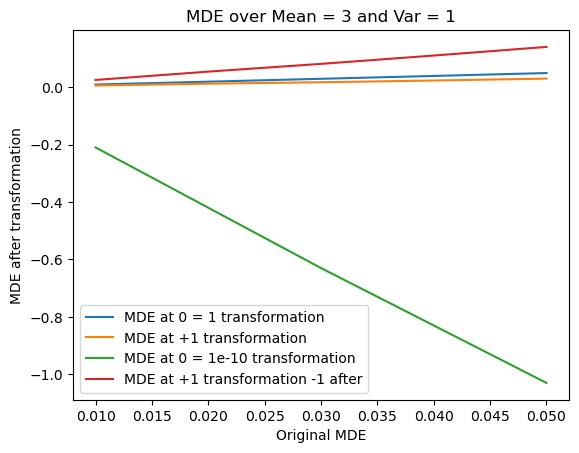

In [59]:
# Mean = 3, var = 1

x = [0.01,0.02,0.03,0.04,0.05]
y0 = [0.009,0.019,0.029,0.039,0.049]
y1 = [0.0055,0.012,0.017,0.023,0.0297]
y10 = [-0.21, -0.42, -0.63, -0.83, -1.03]
y11 = [0.025,0.054,0.081, 0.11 , 0.14]
plt.plot(x, y0, label = "MDE at 0 = 1 transformation")
plt.plot(x, y1, label = "MDE at +1 transformation")
plt.plot(x, y10, label = "MDE at 0 = 1e-10 transformation")
plt.plot(x, y11, label = "MDE at +1 transformation -1 after")
plt.xlabel("Original MDE")
plt.ylabel("MDE after transformation")
plt.title("MDE over Mean = 3 and Var = 1")
plt.legend()
plt.show()

Text(0, 0.5, 'New MDE')

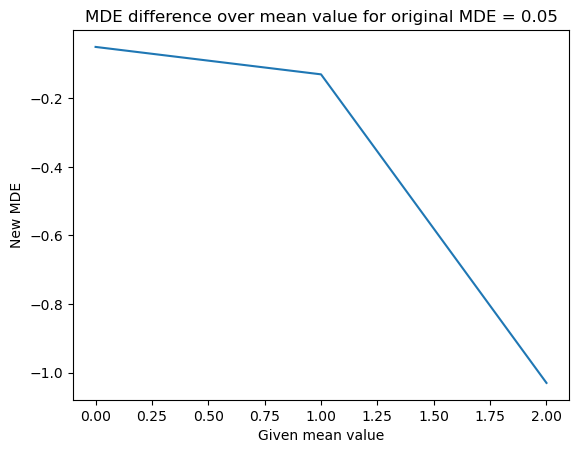

In [60]:
plt.plot([0, 1, 2],[-0.05, -0.13, -1.03])
plt.title("MDE difference over mean value for original MDE = 0.05")
plt.xlabel("Given mean value")
plt.ylabel("New MDE")

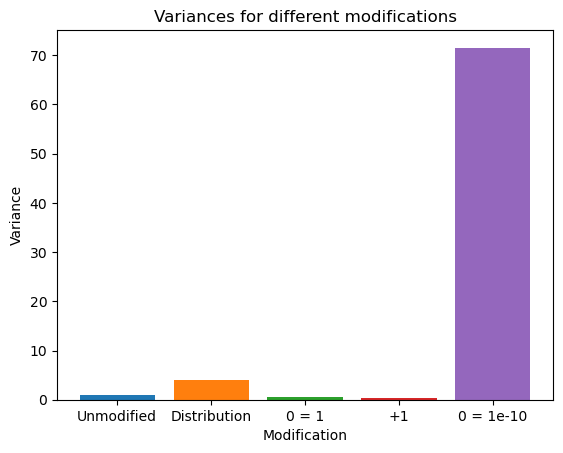

'\nvariance = 3.9963065841989995\nnobs = 2794\nmde = -0.0009478971194773271\nvariance = 0.46060276271470724\nnobs = 9108246\nmde = -0.0006624188491671307\nvariance = 0.40175487835339063\nnobs = 9689017\nmde = 0.002949066339161513\nvariance = 71.5346749722589\nnobs = 23424589\n'

In [65]:
Modifications = ['Unmodified', 'Distribution', '0 = 1', '+1', '0 = 1e-10']
Variances = [1, 4, 0.46, 0.40, 71.53]
#Color = ['blue', 'orange', 'green', 'red', 'purple']
Color = [colors[0], colors[1], colors[2], colors[3], colors[4]]

plt.bar(Modifications, Variances, color=Color)
plt.title('Variances for different modifications')
plt.xlabel('Modification')
plt.ylabel('Variance')
plt.show()
# MDE = 0.05, Mean = 3 and Var = 1

"""
variance = 3.9963065841989995
nobs = 2794
mde = -0.0009478971194773271
variance = 0.46060276271470724
nobs = 9108246
mde = -0.0006624188491671307
variance = 0.40175487835339063
nobs = 9689017
mde = 0.002949066339161513
variance = 71.5346749722589
nobs = 23424589
"""

In [244]:
#rng = np.random.default_rng()
rand_gen = default_rng(seed=chosen_seed)
#rand_gen2 = np.random.default_rng(seed=chosen_seed)
#mean = 3
#var = 3
#nobs = 1000000
# Exempel: Diskret Laplace från SciPy
#print(st.dlaplace.mean(100, loc=3))
#samples = st.dlaplace.rvs(st.dlaplace.var(var**2), loc=mean, size=nobs, random_state=rng)

#print(st.dlaplace.var(np.log(2+np.sqrt(3)), loc=3))
#print(st.dlaplace.var(np.log(2), loc=3))
#print(st.dlaplace.var(np.log(((1+var**2)/(var**2))+np.sqrt((1+2*var**2)/(var**4)))))
#print(np.log(((1+var**2)/(var**2))+np.sqrt((1+2*var**2)/(var**4))))
#samples = sorted(samples)
#plt.plot(samples)
#res = st.dlaplace.rvs(st.dlaplace.var(np.log(var**2)), loc=mean, size=nobs, random_state=rng)

#st.dlaplace.var(np.log(((1+var**2)/(var**2))+np.sqrt((1+2*var**2)/(var**4))))

#samples = st.dlaplace.rvs((np.log(np.sqrt(((1+var)/(var))+np.sqrt((1+2*var)/(var**2))))), loc=mean, size=nobs, random_state=rng)
#samples = st.dlaplace.rvs((np.log(np.sqrt(((1+var)/(var))+np.sqrt((1+2*var)/(var**2))))), loc=mean, size=nobs, random_state=rng)
#samples = st.dlaplace.rvs((np.log((1+var+np.sqrt(1+2*var))/var)), loc=mean, size=nobs, random_state=rng)

#print(np.mean(samples))
#print(np.var(samples))


#print(st.dlaplace.var(1, loc=3))

#count, bins, ignored = plt.hist(samples, 30, density=True)
#x = np.arange(-8., 8., .01)
#plt.plot()
#st.dlaplace.rvs((np.log((1+var+np.sqrt(1+2*var))/var)), loc=mean, size=nobs, random_state=rng)
a = st.dlaplace.rvs((np.log((1+var+np.sqrt(1+2*var))/var)), loc=mean, size=int(points), random_state=rand_gen)
print(np.min(a))
print(np.max(a))
print(np.mean(a))
print(np.var(a))


-8
14
3.000587
1.0017746554309999
